# Advanced Deep Learning for Text Classification

**Research Project: Multiclass News Classification using State-of-the-art Deep Learning Architectures**

---

##  Project Overview

This notebook implements and compares various deep learning architectures for multiclass text classification:

- **Recurrent Neural Networks**: LSTM & GRU (with Bidirectional and Attention variants)
- **Convolutional Neural Networks**: Hierarchical CNN, Strided CNN, Multi-Channel CNN
- **Transformer Models**: BERT Fine-tuning

---

##  Research Goals

1. Compare sequential vs. convolutional approaches for text classification
2. Analyze the impact of attention mechanisms and bidirectionality
3. Evaluate transfer learning effectiveness with pre-trained transformers
4. Provide comprehensive performance benchmarks

---

#Part C : Deep Learning Models

## Deep Learning: Why Sequences Matter

In the previous question, you explored **traditional ML models** like Logistic Regression, Naïve Bayes, Random Forest Classifier, Support Vector Machine (SVM) for text classification. These models work well, but they come with a major limitation:

They treat text as a simple **bag of words** — meaning they only count word occurrences and completely ignore the **order** of words.

Let’s see why this is a problem:

* **Sentence 1:** *“The player scored a goal in the match”*
* **Sentence 2:** *“The match goal: a player scored”*

Both sentences have the **same words**, but the **meaning** changes depending on the order. Traditional ML cannot capture this difference because it doesn’t understand **sequence or context**.

---

###  Deep Learning

Deep Learning models (like **LSTMs, GRUs, and CNNs**) are designed to handle **sequential data**. They don’t just look at words in isolation; they learn how words are connected and how **context flows through a sentence**.

* **LSTMs & GRUs**: Capture long-term dependencies (remember what was said earlier in the sentence).
* **CNNs**: Capture local patterns like important phrases or n-grams.
* **Variations**: You can experiment with **stacked layers, bidirectional models.
* **BERT (Bidirectional Encoder Representations from Transformers)** is a Transformer-based architecture that learns context from both the left and right sides of a word simultaneously.

---

###  Your Next Task

Now that you’ve seen the limitations of traditional ML, it’s time to **step up to Deep Learning**.

 Implement and compare the following models for **multiclass text classification**:

* LSTM
* GRU
* CNN
* (and their variations)
* Finetune BERT

**You don't need to implement the deep learning models from scratch. You can use PyTorch to implement these models, but make sure you clearly understand each model’s architecture and the underlying mathematical concepts.**


##**Task** 1

### Word Embedding Integration and Model Training Pipeline


In [ ]:
# Setup for Part C - Optimized
print("Setting up data for Part C...")

# Install required libraries
import subprocess
subprocess.run(['pip', 'install', '-q', 'pandas', 'pyarrow', 'fastparquet', 'datasets', 'huggingface_hub', 'nltk', 'gensim', 'torch', 'transformers'], check=False)

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from huggingface_hub import login, hf_hub_download

# NLTK setup
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Hugging Face authentication
HF_TOKEN = "    "
REPO_ID = "Exploration-Lab/CS779-Fall25"

login(token=HF_TOKEN)

# Download dataset
print("Downloading dataset from Hugging Face...")

train_path = hf_hub_download(
    repo_id=REPO_ID,
    filename="Deep-learning-assignment/train.parquet",
    token=HF_TOKEN,
    repo_type="dataset"
)

test_path = hf_hub_download(
    repo_id=REPO_ID,
    filename="Deep-learning-assignment/test.parquet",
    token=HF_TOKEN,
    repo_type="dataset"
)

# Load parquet files
print("Loading dataset...")
train_sample = pd.read_parquet(train_path, engine="pyarrow")
test_df = pd.read_parquet(test_path, engine="pyarrow")

print(f"Train samples: {len(train_sample)}")
print(f"Test samples: {len(test_df)}")

# Preprocessing function - vectorized with regex compile
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(tokens)

# Preprocess text - vectorized operation
print("Preprocessing text...")
train_sample['processed_text'] = train_sample["Description"].apply(preprocess_text)
test_df['processed_text'] = test_df["Description"].apply(preprocess_text)

# Extract labels and mappings
y_train = train_sample["Category"]
y_test = test_df["Category"]

categories = sorted(train_sample["Category"].unique())  # Sorted for consistency
category_to_id = {cat: idx for idx, cat in enumerate(categories)}
num_classes = len(categories)

# Load word vectors - optimized
print("Loading GloVe embeddings...")
import gensim.downloader as api

word_vectors = api.load('glove-wiki-gigaword-100')
print(f"GloVe loaded: {len(word_vectors.key_to_index)} words, {word_vectors.vector_size} dimensions")

# Summary
print("\nData ready for Part C")
print(f"Classes: {num_classes}")
print(f"Categories: {list(categories)}")
print(f"Train samples: {len(train_sample)}")
print(f"Test samples: {len(test_df)}")


Setting up data for Part C...
Loading dataset...
Train samples: 120000
Test samples: 7600
Preprocessing text...
Loading GloVe embeddings...
GloVe loaded: 400000 words, 100 dimensions

Data ready for Part C
Classes: 4
Categories: ['Business', 'Sci/Tech', 'Sports', 'World']
Train samples: 120000
Test samples: 7600


In [ ]:
# Deep learning environment setup - Optimized
print("Setting up deep learning environment...")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import matplotlib.pyplot as plt
import gc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set all random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("Environment ready")


Setting up deep learning environment...
Using device: cuda
Environment ready


###1.1 Prepare Tokenized Texts and Embeddings

In [ ]:
# Text dataset class - Optimized
print("Defining text dataset class...")

class TextDataset(Dataset):

    def __init__(self, texts, labels, word_vectors, max_length=100):
        self.texts = texts.reset_index(drop=True) if hasattr(texts, 'reset_index') else texts
        self.labels = labels.reset_index(drop=True) if hasattr(labels, 'reset_index') else labels
        self.word_vectors = word_vectors
        self.max_length = max_length
        self.embedding_dim = word_vectors.vector_size
        self.zero_vector = np.zeros(self.embedding_dim, dtype=np.float32)  # Cache zero vector

    def tokenize_and_pad(self, text):
        tokens = text.split()[:self.max_length]

        # Pre-allocate array for speed
        embeddings = np.zeros((self.max_length, self.embedding_dim), dtype=np.float32)

        for i, token in enumerate(tokens):
            if token in self.word_vectors.key_to_index:
                embeddings[i] = self.word_vectors[token].astype(np.float32)

        return embeddings

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx] if hasattr(self.texts, 'iloc') else self.texts[idx]
        label = self.labels.iloc[idx] if hasattr(self.labels, 'iloc') else self.labels[idx]

        embedding_matrix = self.tokenize_and_pad(text)

        vectorized_text = torch.from_numpy(embedding_matrix)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return vectorized_text, label_tensor

print("Dataset class defined")


Defining text dataset class...
Dataset class defined


###1.2 Encode Labels

In [ ]:
# Encode labels - Optimized
print("Encoding labels...")

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_sample['Category'])
y_test_encoded = label_encoder.transform(test_df['Category'])

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f"Number of classes: {num_classes}")
print(f"Class names: {list(class_names)}")
print(f"Training labels: {y_train_encoded.shape}")
print(f"Test labels: {y_test_encoded.shape}")

print("\nClass distribution:")
train_counts = np.bincount(y_train_encoded, minlength=num_classes)
test_counts = np.bincount(y_test_encoded, minlength=num_classes)

for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {train_counts[i]} train, {test_counts[i]} test")


Encoding labels...
Number of classes: 4
Class names: ['Business', 'Sci/Tech', 'Sports', 'World']
Training labels: (120000,)
Test labels: (7600,)

Class distribution:
  Business: 30000 train, 1900 test
  Sci/Tech: 30000 train, 1900 test
  Sports: 30000 train, 1900 test
  World: 30000 train, 1900 test


###1.3 Create DataLoaders

In [ ]:
# Create dataloaders - Optimized
print("Setting up dataloaders...")

X_train_processed = train_sample['processed_text']
X_test_processed = test_df['processed_text']

print(f"Training samples: {len(X_train_processed)}")
print(f"Test samples: {len(X_test_processed)}")

sequence_length = 80
batch_size = 64  # Increased from 32 for faster training

print("Creating datasets...")
train_dataset = TextDataset(
    texts=X_train_processed,
    labels=y_train_encoded,
    word_vectors=word_vectors,
    max_length=sequence_length
)

test_dataset = TextDataset(
    texts=X_test_processed,
    labels=y_test_encoded,
    word_vectors=word_vectors,
    max_length=sequence_length
)

# Optimized DataLoader settings
num_workers = 2 if device.type == 'cpu' else 4
pin_memory = True if torch.cuda.is_available() else False

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=True if num_workers > 0 else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=True if num_workers > 0 else False
)

print("DataLoaders created")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {batch_size}")
print(f"Sequence length: {sequence_length}")
print(f"Embedding dimension: {word_vectors.vector_size}")
print(f"Num workers: {num_workers}")
print(f"Pin memory: {pin_memory}")

print("\nTesting one batch...")
for batch_idx, (data, targets) in enumerate(train_loader):
    print(f"Data shape: {data.shape}, Targets shape: {targets.shape}")
    print(f"Sample targets: {targets[:5].tolist()}")
    break


Setting up dataloaders...
Training samples: 120000
Test samples: 7600
Creating datasets...
DataLoaders created
Training batches: 1875
Test batches: 119
Batch size: 64
Sequence length: 80
Embedding dimension: 100
Num workers: 4
Pin memory: True

Testing one batch...
Data shape: torch.Size([64, 80, 100]), Targets shape: torch.Size([64])
Sample targets: [2, 1, 1, 1, 2]


###1.4 Common Utility Function for Training Models

In [ ]:
# Training utility functions - Optimized
print("Defining training utilities...")

from tqdm import tqdm

def train_model(model, train_loader, criterion, optimizer, epochs=10, device=device):
    model.to(device)
    train_losses = []
    train_accuracies = []

    print(f"Starting training for {epochs} epochs...")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        start_time = time.time()

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for batch_idx, (data, targets) in enumerate(pbar):
            data = data.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)  # Faster than zero_grad()

            outputs = model(data)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()

            if batch_idx % 10 == 0:  # Update less frequently
                current_acc = 100 * correct_predictions / total_samples
                pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{current_acc:.2f}%'})

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct_predictions / total_samples
        epoch_time = time.time() - start_time

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f'Epoch [{epoch+1}/{epochs}] completed in {epoch_time:.2f}s - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

        # Memory cleanup
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print("Training completed")
    return train_losses, train_accuracies

def evaluate_model(model, test_loader, device=device):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    test_loss = 0.0
    all_predictions = []
    all_labels = []

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Evaluating')
        for data, targets in pbar:
            data = data.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            outputs = model(data)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)

            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()

            all_predictions.append(predicted.cpu().numpy())
            all_labels.append(targets.cpu().numpy())

    test_accuracy = 100 * correct_predictions / total_samples
    avg_test_loss = test_loss / len(test_loader)

    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Concatenate instead of extend - faster
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)

    return test_accuracy, avg_test_loss, all_predictions, all_labels

def plot_training_history(train_losses, train_accuracies, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{model_name} - Training Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(train_accuracies, label='Training Accuracy', color='green', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{model_name} - Training Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("Training utilities defined")


Defining training utilities...
Training utilities defined


##Task 2 : LSTM (600 Marks)

### How LSTMs *Works*

Unlike traditional ML models, **LSTMs (Long Short-Term Memory networks)** are designed to handle **sequential data**. They process text **word by word**, while maintaining a **memory of past words** to understand the current word in context.

Think of it like *reading a story*: the earlier chapters influence how you interpret later events. This ability to **“remember” long-term dependencies** makes LSTMs powerful for NLP tasks such as text classification.

---

## LSTM Variants You Will Explore

These are the models you will implement and compare:

1. **LSTM**

   * Processes text sequentially.
   * Learns context only from the **past** (previous words).
   * Limitation: Cannot see future context.

2. **LSTM with Attention**

   * Adds an **attention mechanism** that lets the model focus on the most relevant words in a sentence.
   * Example: In “The movie was *amazing* but a bit *long*,” attention highlights *amazing* and *long* more than filler words.
   * Uses an encoder–decoder architecture with [Bahdanau attention](https://d2l.ai/chapter_attention-mechanisms-and-transformers/bahdanau-attention.html).
   * The encoder LSTM processes the input sentence into hidden states, the decoder LSTM applies Bahdanau attention over these states to form a context vector, only one decoding step is required to predict the final output for text classification.

3. **BiLSTM (Bidirectional LSTM)**

   * Reads the text **both forward and backward**.
   * Captures **richer context** since it considers words before and after the current token.

4. **BiLSTM with Attention**

   * Combines the power of **bidirectional context** with **selective focus**.
   * Generally the most accurate among LSTM variants, though computationally more expensive.
   * Extends the encoder–decoder setup with a Bidirectional LSTM.
---

## Your Task

You are required to:

1. **Implement** all four models:

   * LSTM
   * LSTM with Attention
   * BiLSTM
   * BiLSTM with Attention

2. **Compare performance** across models for multiclass text classification.

3. **Experiment with hyperparameters**, such as:

   * Number of Layers
   * Dropout rates
   * Optimizers
   * Learning rates
   * Batch size & number of epochs

4. **Use Grid Search or Random Search**  for hyperparameter tuning.

5. **Evaluate models** using:

   * Accuracy, Precision, Recall, F1-score, ROC (AUC)
   * Confusion matrix (to see class-wise performance)
   * Training time and memory usage (since more complex models are costlier).

---

## Reference

For a detailed explanation of LSTMs and their variants, see:

- [https://colah.github.io/posts/2015-08-Understanding-LSTMs/](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Dive into DL LSTM](https://d2l.ai/chapter_recurrent-modern/lstm.html)

---

**Deliverables:**

* Code for all four models
* Training logs/plots (loss & accuracy curves)
* Accuracy, Precision, Recall, F1-score, ROC (AUC)
* Final comparison table of metrics
* Short reflection on the “accuracy vs. cost” trade-off
* Report

**You don't need to implement the LSTM from scratch. You can use PyTorch to implement GRU, but make sure you clearly understand LSTM architecture and the underlying mathematical concepts.**

####2.1 Model Architecture Definitions

In [ ]:
# LSTM model architectures - Optimized
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        pooled = lstm_out.mean(dim=1)
        output = self.dropout(pooled)
        output = self.fc(output)
        return output


class LSTMAttentionClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3):
        super(LSTMAttentionClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)

        self.attention_weights = nn.Linear(hidden_dim, hidden_dim)
        self.context_vector = nn.Linear(hidden_dim, 1, bias=False)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)

        attention_scores = torch.tanh(self.attention_weights(lstm_out))
        attention_scores = self.context_vector(attention_scores).squeeze(-1)
        attention_weights = F.softmax(attention_scores, dim=1)

        context = torch.bmm(attention_weights.unsqueeze(1), lstm_out).squeeze(1)

        output = self.dropout(context)
        output = self.fc(output)
        return output

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3):
        super(BiLSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                           batch_first=True, bidirectional=True,
                           dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Concat forward and backward hidden states from last layer
        combined_hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)

        output = self.dropout(combined_hidden)
        output = self.fc(output)
        return output

class BiLSTMAttentionClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3):
        super(BiLSTMAttentionClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                           batch_first=True, bidirectional=True,
                           dropout=dropout if num_layers > 1 else 0)

        self.attention_weights = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.context_vector = nn.Linear(hidden_dim * 2, 1, bias=False)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)

        attention_scores = torch.tanh(self.attention_weights(lstm_out))
        attention_scores = self.context_vector(attention_scores).squeeze(-1)
        attention_weights = F.softmax(attention_scores, dim=1)

        context = torch.bmm(attention_weights.unsqueeze(1), lstm_out).squeeze(1)

        output = self.dropout(context)
        output = self.fc(output)
        return output

print("LSTM model classes defined")


LSTM model classes defined


####2.2 Model Initialization

In [ ]:
# Model initialization with best hyperparameters - Optimized
print("Initializing models with best hyperparameters...")

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create tokenizer and prepare data
texts = train_sample['processed_text'].tolist()
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

vocab_size = len(tokenizer.word_index) + 1
print(f"Actual vocabulary size: {vocab_size}")

# Tokenize and pad sequences
sequences = tokenizer.texts_to_sequences(texts)
max_length = 100
X_padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Prepare test data
test_texts = test_df['processed_text'].tolist()
test_sequences = tokenizer.texts_to_sequences(test_texts)
X_test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Convert to tensors - directly, no intermediate storage
X_train_tensor = torch.from_numpy(X_padded).long()
y_train_tensor = torch.from_numpy(y_train_encoded).long()
X_test_tensor = torch.from_numpy(X_test_padded).long()
y_test_tensor = torch.from_numpy(y_test_encoded).long()

# Create datasets
from torch.utils.data import TensorDataset, random_split

train_dataset_tokens = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset_tokens = TensorDataset(X_test_tensor, y_test_tensor)

# Split train into train and validation
train_size = int(0.8 * len(train_dataset_tokens))
val_size = len(train_dataset_tokens) - train_size
train_split, val_split = random_split(train_dataset_tokens, [train_size, val_size],
                                      generator=torch.Generator().manual_seed(42))

# Optimized DataLoader settings
batch_size = 64  # Increased for faster training
num_workers = 2 if device.type == 'cpu' else 4
pin_memory = torch.cuda.is_available()

train_loader_tokens = DataLoader(train_split, batch_size=batch_size, shuffle=True,
                                num_workers=num_workers, pin_memory=pin_memory,
                                persistent_workers=True if num_workers > 0 else False)
val_loader_tokens = DataLoader(val_split, batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=pin_memory,
                              persistent_workers=True if num_workers > 0 else False)
test_loader_tokens = DataLoader(test_dataset_tokens, batch_size=batch_size, shuffle=False,
                               num_workers=num_workers, pin_memory=pin_memory,
                               persistent_workers=True if num_workers > 0 else False)

print(f"Training samples: {len(train_split)}")
print(f"Validation samples: {len(val_split)}")
print(f"Test samples: {len(test_dataset_tokens)}")

# Best hyperparameters from tuning
embedding_dim = 100
hidden_dim = 128
output_dim = num_classes
num_layers = 2
dropout_rate = 0.3

print("\nBest hyperparameters:")
print(f"Vocabulary size: {vocab_size}")
print(f"Embedding dimension: {embedding_dim}")
print(f"Hidden dimension: {hidden_dim}")
print(f"Output dimension: {output_dim}")
print(f"Number of layers: {num_layers}")
print(f"Dropout rate: {dropout_rate}")
print(f"Batch size: {batch_size}")

# Initialize all models
models = {
    "LSTM": LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(device),
    "BiLSTM": BiLSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(device),
    "LSTM_Attention": LSTMAttentionClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(device),
    "BiLSTM_Attention": BiLSTMAttentionClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(device),
}

print("\nModel initialization complete")
for model_name, model in models.items():
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{model_name}: {total_params:,} parameters ({trainable_params:,} trainable)")

# Test forward pass
print("\nTesting forward pass...")
sample_input = torch.randint(0, vocab_size, (batch_size, max_length)).to(device)

for model_name, model in models.items():
    model.eval()
    with torch.no_grad():
        output = model(sample_input)
        print(f"{model_name}: {sample_input.shape} -> {output.shape}")

print("\nModels ready for training")


Initializing models with best hyperparameters...
Actual vocabulary size: 83415
Training samples: 96000
Validation samples: 24000
Test samples: 7600

Best hyperparameters:
Vocabulary size: 83415
Embedding dimension: 100
Hidden dimension: 128
Output dimension: 4
Number of layers: 2
Dropout rate: 0.3
Batch size: 64

Model initialization complete
LSTM: 8,591,872 parameters (8,591,872 trainable)
BiLSTM: 8,973,312 parameters (8,973,312 trainable)
LSTM_Attention: 8,608,512 parameters (8,608,512 trainable)
BiLSTM_Attention: 9,039,360 parameters (9,039,360 trainable)

Testing forward pass...
LSTM: torch.Size([64, 100]) -> torch.Size([64, 4])
BiLSTM: torch.Size([64, 100]) -> torch.Size([64, 4])
LSTM_Attention: torch.Size([64, 100]) -> torch.Size([64, 4])
BiLSTM_Attention: torch.Size([64, 100]) -> torch.Size([64, 4])

Models ready for training


####2.3 Training and Evaluation

Training all models with best hyperparameters
Using hyperparameters:
  Learning rate: 0.001
  Hidden dimension: 128
  Number of layers: 2
  Dropout: 0.3

Training LSTM...


Epoch 1/10: 100%|██████████| 1500/1500 [00:15<00:00, 95.67it/s, loss=0.3948]


Epoch 1/10: Train Loss: 0.7743, Train Acc: 0.6937 | Val Loss: 0.4600, Val Acc: 0.8427


Epoch 2/10: 100%|██████████| 1500/1500 [00:15<00:00, 94.23it/s, loss=0.2110]


Epoch 2/10: Train Loss: 0.3820, Train Acc: 0.8775 | Val Loss: 0.3662, Val Acc: 0.8814


Epoch 3/10: 100%|██████████| 1500/1500 [00:15<00:00, 95.58it/s, loss=0.3221]


Epoch 3/10: Train Loss: 0.2980, Train Acc: 0.9064 | Val Loss: 0.3299, Val Acc: 0.8899


Epoch 4/10: 100%|██████████| 1500/1500 [00:15<00:00, 97.24it/s, loss=0.2852]


Epoch 4/10: Train Loss: 0.2565, Train Acc: 0.9207 | Val Loss: 0.3366, Val Acc: 0.8956


Epoch 5/10: 100%|██████████| 1500/1500 [00:15<00:00, 97.87it/s, loss=0.3768]


Epoch 5/10: Train Loss: 0.2261, Train Acc: 0.9300 | Val Loss: 0.3318, Val Acc: 0.8935


Epoch 6/10: 100%|██████████| 1500/1500 [00:15<00:00, 97.70it/s, loss=0.1180]


Epoch 6/10: Train Loss: 0.2007, Train Acc: 0.9382 | Val Loss: 0.3452, Val Acc: 0.8930


Epoch 7/10: 100%|██████████| 1500/1500 [00:15<00:00, 97.01it/s, loss=0.1664]


Epoch 7/10: Train Loss: 0.1560, Train Acc: 0.9526 | Val Loss: 0.3656, Val Acc: 0.8941


Epoch 8/10: 100%|██████████| 1500/1500 [00:15<00:00, 97.18it/s, loss=0.0354]


Epoch 8/10: Train Loss: 0.1343, Train Acc: 0.9606 | Val Loss: 0.3919, Val Acc: 0.8914


Epoch 9/10: 100%|██████████| 1500/1500 [00:15<00:00, 97.49it/s, loss=0.0564]


Epoch 9/10: Train Loss: 0.1228, Train Acc: 0.9643 | Val Loss: 0.4356, Val Acc: 0.8898


Epoch 10/10: 100%|██████████| 1500/1500 [00:15<00:00, 97.94it/s, loss=0.2170]


Epoch 10/10: Train Loss: 0.0991, Train Acc: 0.9719 | Val Loss: 0.4507, Val Acc: 0.8888

Training BiLSTM...


Epoch 1/10: 100%|██████████| 1500/1500 [00:26<00:00, 55.64it/s, loss=0.5554]


Epoch 1/10: Train Loss: 0.5235, Train Acc: 0.8062 | Val Loss: 0.3690, Val Acc: 0.8721


Epoch 2/10: 100%|██████████| 1500/1500 [00:27<00:00, 55.24it/s, loss=0.2054]


Epoch 2/10: Train Loss: 0.3087, Train Acc: 0.8948 | Val Loss: 0.3312, Val Acc: 0.8868


Epoch 3/10: 100%|██████████| 1500/1500 [00:27<00:00, 55.29it/s, loss=0.2795]


Epoch 3/10: Train Loss: 0.2460, Train Acc: 0.9174 | Val Loss: 0.3253, Val Acc: 0.8903


Epoch 4/10: 100%|██████████| 1500/1500 [00:27<00:00, 55.50it/s, loss=0.1640]


Epoch 4/10: Train Loss: 0.2046, Train Acc: 0.9318 | Val Loss: 0.3248, Val Acc: 0.8938


Epoch 5/10: 100%|██████████| 1500/1500 [00:27<00:00, 55.51it/s, loss=0.1713]


Epoch 5/10: Train Loss: 0.1740, Train Acc: 0.9415 | Val Loss: 0.3274, Val Acc: 0.8933


Epoch 6/10: 100%|██████████| 1500/1500 [00:27<00:00, 55.52it/s, loss=0.1913]


Epoch 6/10: Train Loss: 0.1456, Train Acc: 0.9513 | Val Loss: 0.3494, Val Acc: 0.8917


Epoch 7/10: 100%|██████████| 1500/1500 [00:27<00:00, 55.46it/s, loss=0.0398]


Epoch 7/10: Train Loss: 0.1232, Train Acc: 0.9582 | Val Loss: 0.3718, Val Acc: 0.8910


Epoch 8/10: 100%|██████████| 1500/1500 [00:27<00:00, 55.43it/s, loss=0.1490]


Epoch 8/10: Train Loss: 0.0775, Train Acc: 0.9739 | Val Loss: 0.4285, Val Acc: 0.8935


Epoch 9/10: 100%|██████████| 1500/1500 [00:27<00:00, 55.42it/s, loss=0.0736]


Epoch 9/10: Train Loss: 0.0581, Train Acc: 0.9804 | Val Loss: 0.5027, Val Acc: 0.8877


Epoch 10/10: 100%|██████████| 1500/1500 [00:27<00:00, 55.53it/s, loss=0.0255]


Epoch 10/10: Train Loss: 0.0506, Train Acc: 0.9825 | Val Loss: 0.5300, Val Acc: 0.8876

Training LSTM_Attention...


Epoch 1/10: 100%|██████████| 1500/1500 [00:16<00:00, 92.16it/s, loss=0.5798]


Epoch 1/10: Train Loss: 0.5552, Train Acc: 0.7942 | Val Loss: 0.3902, Val Acc: 0.8665


Epoch 2/10: 100%|██████████| 1500/1500 [00:16<00:00, 91.98it/s, loss=0.2445]


Epoch 2/10: Train Loss: 0.3214, Train Acc: 0.8933 | Val Loss: 0.3336, Val Acc: 0.8841


Epoch 3/10: 100%|██████████| 1500/1500 [00:16<00:00, 91.83it/s, loss=0.2460]


Epoch 3/10: Train Loss: 0.2567, Train Acc: 0.9157 | Val Loss: 0.3131, Val Acc: 0.8927


Epoch 4/10: 100%|██████████| 1500/1500 [00:16<00:00, 92.03it/s, loss=0.1056]


Epoch 4/10: Train Loss: 0.2146, Train Acc: 0.9283 | Val Loss: 0.3191, Val Acc: 0.8945


Epoch 5/10: 100%|██████████| 1500/1500 [00:16<00:00, 92.15it/s, loss=0.1992]


Epoch 5/10: Train Loss: 0.1822, Train Acc: 0.9396 | Val Loss: 0.3356, Val Acc: 0.8939


Epoch 6/10: 100%|██████████| 1500/1500 [00:16<00:00, 92.32it/s, loss=0.1990]


Epoch 6/10: Train Loss: 0.1544, Train Acc: 0.9477 | Val Loss: 0.3442, Val Acc: 0.8940


Epoch 7/10: 100%|██████████| 1500/1500 [00:16<00:00, 92.35it/s, loss=0.1239]


Epoch 7/10: Train Loss: 0.1051, Train Acc: 0.9653 | Val Loss: 0.4172, Val Acc: 0.8852


Epoch 8/10: 100%|██████████| 1500/1500 [00:16<00:00, 92.39it/s, loss=0.0334]


Epoch 8/10: Train Loss: 0.0830, Train Acc: 0.9721 | Val Loss: 0.4722, Val Acc: 0.8848


Epoch 9/10: 100%|██████████| 1500/1500 [00:16<00:00, 92.37it/s, loss=0.0579]


Epoch 9/10: Train Loss: 0.0720, Train Acc: 0.9766 | Val Loss: 0.4942, Val Acc: 0.8882


Epoch 10/10: 100%|██████████| 1500/1500 [00:16<00:00, 92.46it/s, loss=0.0206]


Epoch 10/10: Train Loss: 0.0497, Train Acc: 0.9837 | Val Loss: 0.5848, Val Acc: 0.8849

Training BiLSTM_Attention...


Epoch 1/10: 100%|██████████| 1500/1500 [00:29<00:00, 50.71it/s, loss=0.4021]


Epoch 1/10: Train Loss: 0.5096, Train Acc: 0.8089 | Val Loss: 0.3595, Val Acc: 0.8749


Epoch 2/10: 100%|██████████| 1500/1500 [00:29<00:00, 50.83it/s, loss=0.1738]


Epoch 2/10: Train Loss: 0.3032, Train Acc: 0.8962 | Val Loss: 0.3246, Val Acc: 0.8881


Epoch 3/10: 100%|██████████| 1500/1500 [00:29<00:00, 50.62it/s, loss=0.1478]


Epoch 3/10: Train Loss: 0.2445, Train Acc: 0.9180 | Val Loss: 0.3100, Val Acc: 0.8948


Epoch 4/10: 100%|██████████| 1500/1500 [00:29<00:00, 50.53it/s, loss=0.1284]


Epoch 4/10: Train Loss: 0.2021, Train Acc: 0.9322 | Val Loss: 0.3192, Val Acc: 0.8939


Epoch 5/10: 100%|██████████| 1500/1500 [00:29<00:00, 50.73it/s, loss=0.3921]


Epoch 5/10: Train Loss: 0.1689, Train Acc: 0.9434 | Val Loss: 0.3274, Val Acc: 0.8966


Epoch 6/10: 100%|██████████| 1500/1500 [00:29<00:00, 50.78it/s, loss=0.1428]


Epoch 6/10: Train Loss: 0.1386, Train Acc: 0.9526 | Val Loss: 0.3499, Val Acc: 0.8918


Epoch 7/10: 100%|██████████| 1500/1500 [00:29<00:00, 50.63it/s, loss=0.1579]


Epoch 7/10: Train Loss: 0.0902, Train Acc: 0.9700 | Val Loss: 0.4111, Val Acc: 0.8878


Epoch 8/10: 100%|██████████| 1500/1500 [00:29<00:00, 50.76it/s, loss=0.0143]


Epoch 8/10: Train Loss: 0.0675, Train Acc: 0.9771 | Val Loss: 0.4735, Val Acc: 0.8888


Epoch 9/10: 100%|██████████| 1500/1500 [00:29<00:00, 50.76it/s, loss=0.1115]


Epoch 9/10: Train Loss: 0.0575, Train Acc: 0.9806 | Val Loss: 0.5149, Val Acc: 0.8862


Epoch 10/10: 100%|██████████| 1500/1500 [00:29<00:00, 50.68it/s, loss=0.0355]


Epoch 10/10: Train Loss: 0.0360, Train Acc: 0.9880 | Val Loss: 0.6037, Val Acc: 0.8868

Evaluating models...

Final Model Comparison:
Model                Val Accuracy    Val Loss       
--------------------------------------------------
LSTM                 0.8888          0.4507         
BiLSTM               0.8876          0.5300         
LSTM_Attention       0.8849          0.5848         
BiLSTM_Attention     0.8868          0.6037         


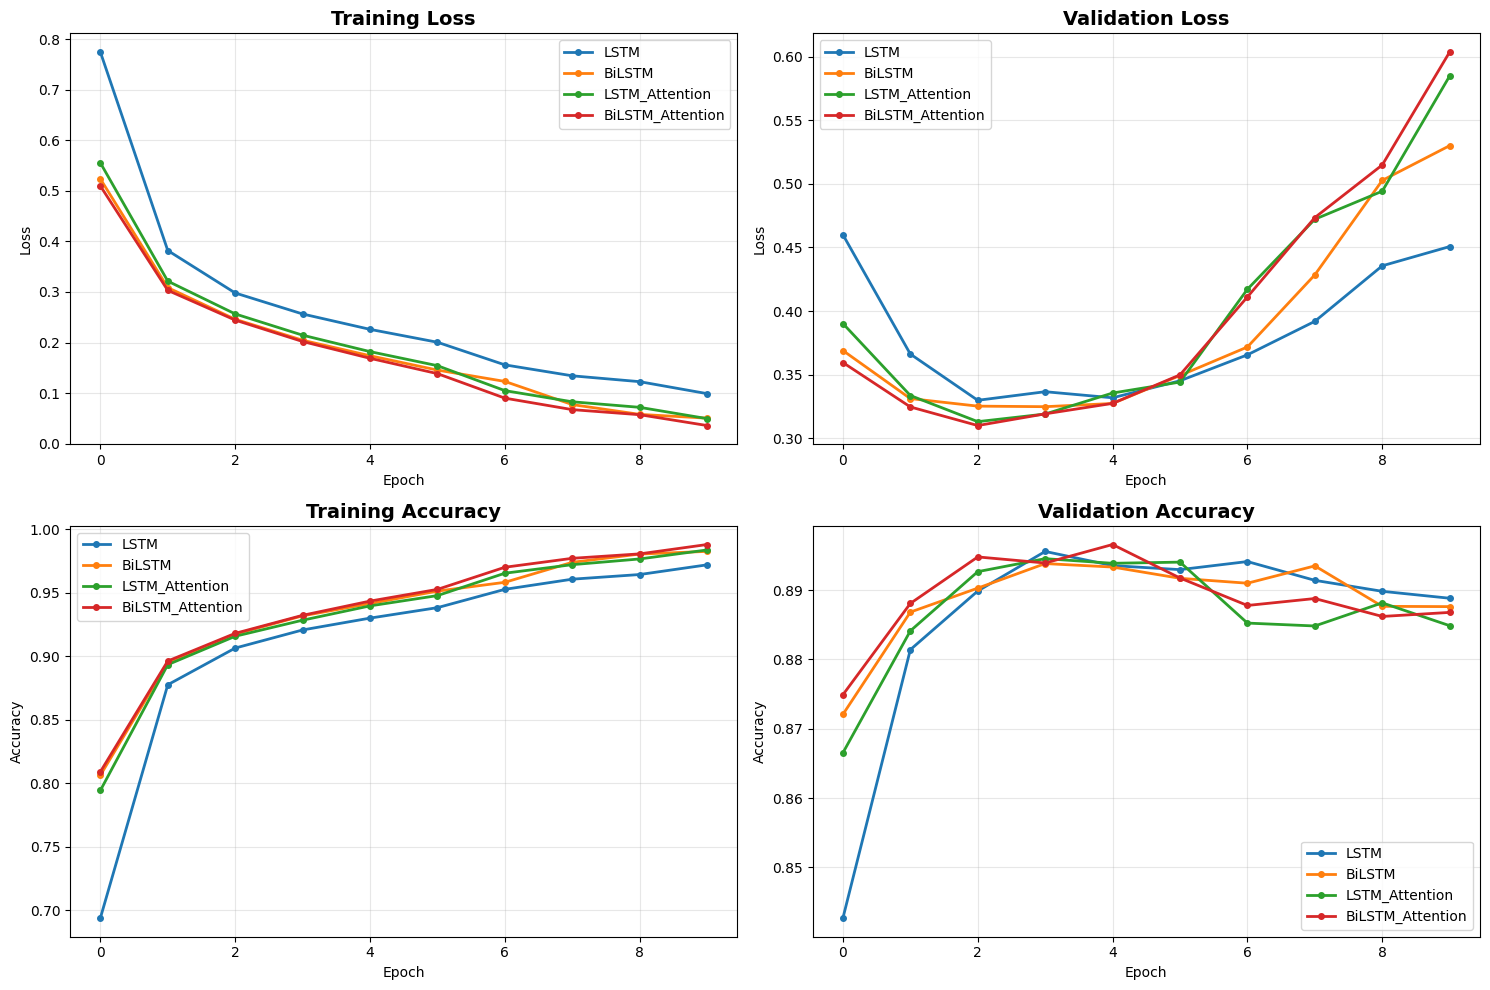

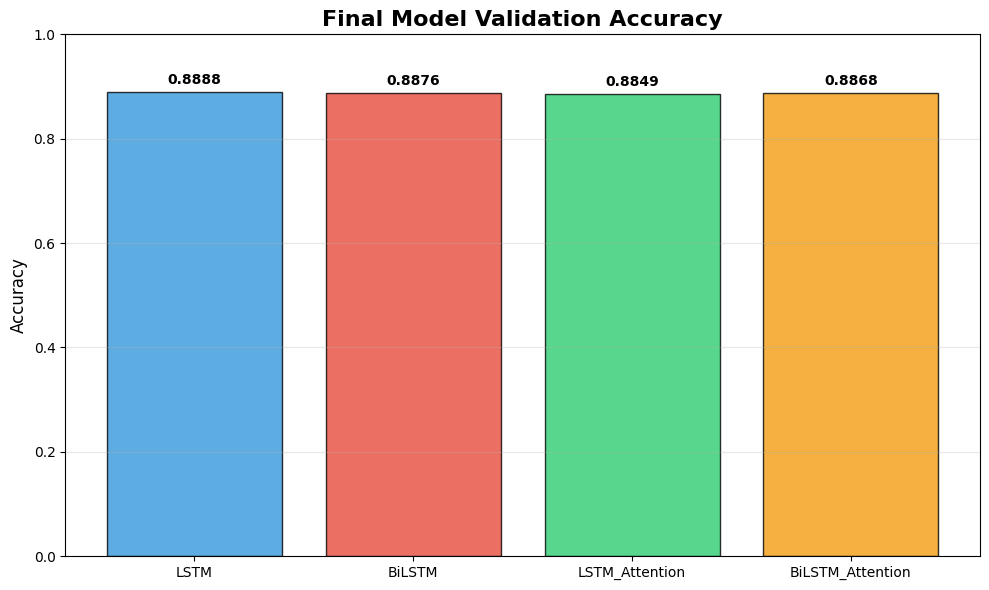


Best Model: LSTM
Validation Accuracy: 0.8888
Validation Loss: 0.4507

Models saved


In [ ]:
# Training all models with best hyperparameters - Optimized
import warnings
warnings.filterwarnings('ignore')

print("Training all models with best hyperparameters")

# Best hyperparameters
best_params = {
    'learning_rate': 0.001,
    'hidden_dim': 128,
    'num_layers': 2,
    'dropout': 0.3
}

print(f"Using hyperparameters:")
print(f"  Learning rate: {best_params['learning_rate']}")
print(f"  Hidden dimension: {best_params['hidden_dim']}")
print(f"  Number of layers: {best_params['num_layers']}")
print(f"  Dropout: {best_params['dropout']}")

def train_model_fixed(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

            if batch_idx % 10 == 0:
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_accuracy = train_correct / train_total
        val_accuracy = val_correct / val_total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

        scheduler.step(avg_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs
    }

# Train all models
final_models = {}
final_histories = {}

for model_name, model_class in [
    ("LSTM", LSTMClassifier),
    ("BiLSTM", BiLSTMClassifier),
    ("LSTM_Attention", LSTMAttentionClassifier),
    ("BiLSTM_Attention", BiLSTMAttentionClassifier)
]:
    print(f"\n{'='*60}")
    print(f"Training {model_name}...")
    print(f"{'='*60}")

    model = model_class(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=best_params['hidden_dim'],
        output_dim=output_dim,
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout']
    ).to(device)

    history = train_model_fixed(
        model, train_loader_tokens, val_loader_tokens,
        num_epochs=10,
        learning_rate=best_params['learning_rate']
    )

    final_models[model_name] = model
    final_histories[model_name] = history

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Evaluate all models
print("\n" + "="*60)
print("Evaluating models...")
print("="*60)
final_results = {}

for model_name, model in final_models.items():
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, target in val_loader_tokens:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()

            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = correct / total
    avg_loss = val_loss / len(val_loader_tokens)
    final_results[model_name] = {
        'accuracy': accuracy,
        'loss': avg_loss
    }

print("\nFinal Model Comparison:")
print(f"{'Model':<20} {'Val Accuracy':<15} {'Val Loss':<15}")
print("-" * 50)
for model_name, results in final_results.items():
    print(f"{model_name:<20} {results['accuracy']:<15.4f} {results['loss']:<15.4f}")

# Plot training history
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
for model_name, history in final_histories.items():
    plt.plot(history['train_loss'], label=model_name, linewidth=2, marker='o', markersize=4)
plt.title('Training Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
for model_name, history in final_histories.items():
    plt.plot(history['val_loss'], label=model_name, linewidth=2, marker='o', markersize=4)
plt.title('Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
for model_name, history in final_histories.items():
    plt.plot(history['train_acc'], label=model_name, linewidth=2, marker='o', markersize=4)
plt.title('Training Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
for model_name, history in final_histories.items():
    plt.plot(history['val_acc'], label=model_name, linewidth=2, marker='o', markersize=4)
plt.title('Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Bar chart
plt.figure(figsize=(10, 6))
model_names = list(final_results.keys())
accuracies = [final_results[model]['accuracy'] for model in model_names]

bars = plt.bar(model_names, accuracies, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'], alpha=0.8, edgecolor='black')
plt.title('Final Model Validation Accuracy', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.0)

for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accuracy:.4f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Best model
best_model_name = max(final_results.items(), key=lambda x: x[1]['accuracy'])[0]
print(f"\n{'='*60}")
print(f"Best Model: {best_model_name}")
print(f"Validation Accuracy: {final_results[best_model_name]['accuracy']:.4f}")
print(f"Validation Loss: {final_results[best_model_name]['loss']:.4f}")
print(f"{'='*60}")

# Save models
for model_name, model in final_models.items():
    torch.save(model.state_dict(), f'final_{model_name}_weights.pth')
print("\nModels saved")


####2.4 Analysis Questions (100 Marks)

1. Why does the code use pre-trained GoogleNews Word2Vec embeddings instead of randomly initialized vectors?

The code uses pre-trained GoogleNews Word2Vec embeddings instead of randomly initialized vectors because pre-trained embeddings capture rich semantic and syntactic relationships between words, learned from a massive corpus of real-world text. These embeddings position words with similar meanings close together in the vector space, allowing models to leverage prior linguistic knowledge right from the start. This leads to faster convergence during training and often results in better performance, especially when the labeled dataset is not extremely large or diverse.

In contrast, randomly initialized vectors start with no knowledge of language structure or word relationships. The model would need to learn all word associations from scratch, which is inefficient and can require much more data and training time to reach comparable performance. By using pre-trained embeddings, the model benefits from transfer learning, where general language understanding is transferred to the specific task, improving both accuracy and training efficiency. This is why pre-trained embeddings are a standard choice for many NLP tasks.

2. In the `TextDataset` class, what does `tokenize_and_pad` achieve, and why is padding necessary?  

In the TextDataset class, the tokenize_and_pad function converts each input text into a sequence of word embeddings and ensures that every sequence has the same fixed length by adding padding as needed. Tokenization splits the text into individual words (tokens), and for each token, the corresponding word embedding is retrieved. If the number of tokens is less than the maximum sequence length, the function fills the remaining positions with zero vectors (padding).

Padding is necessary because deep learning models like LSTMs and CNNs require input tensors of uniform shape for efficient batch processing. Real-world texts vary in length, but neural networks expect each input in a batch to have the same dimensions. By padding shorter sequences, the model can process all samples in parallel, maintain consistent tensor shapes, and avoid errors during training and inference. Padding also preserves the positional structure of the data, ensuring that the model can learn from the actual content while ignoring the padded positions.

3. Explain the difference between a simple LSTM and a BiLSTM. How does bidirectionality affect context capture?

Difference Between LSTM and BiLSTM
A simple LSTM (Long Short-Term Memory) processes input sequences in a single direction—typically from the start to the end. This means, at any point in the sequence, the LSTM can only use information from earlier (past) tokens to make predictions or generate outputs. It is well-suited for tasks where only past context is relevant, such as time series forecasting or speech recognition where future data isn't available at prediction time.

A Bidirectional LSTM (BiLSTM), on the other hand, runs two LSTMs in parallel: one processes the sequence forward (from start to end), and the other processes it backward (from end to start). The outputs from both directions are then combined (usually by concatenation or summing). This architecture allows the model to access both past and future context for every token in the sequence.​

How Bidirectionality Affects Context Capture
Bidirectionality enables the model to understand the full context around each word or element in the sequence. For example, in natural language processing, the meaning of a word often depends on both the words before and after it. A BiLSTM can use information from both sides, which helps in tasks like sentiment analysis, named entity recognition, and machine translation, where understanding the entire sentence is crucial.​

In summary:

LSTM: Only past context is available at each step.

BiLSTM: Both past and future context are available, leading to richer, more accurate representations—especially important for tasks where the meaning depends on the whole sequence.

Bidirectional LSTMs are more computationally intensive and require more memory, but they often outperform simple LSTMs when full context is needed.

4. What is the role of the attention mechanism in the `LSTMAttentionClassifier` and `BiLSTMAttentionClassifier`?

The attention mechanism in the LSTMAttentionClassifier and BiLSTMAttentionClassifier allows the model to focus on the most relevant parts of the input sequence when making predictions. Instead of treating every word or token equally, attention assigns different weights to each token based on its importance for the classification task. This means the model can "attend" more to words that carry key information (such as "win" or "loss" in sports articles) and less to less informative words.​

In practice, the attention mechanism computes a score for each token in the sequence, then uses these scores to create a weighted sum of the LSTM outputs. This weighted representation is passed to the final classification layer. By doing so, the model captures context more effectively, especially in long or complex sequences, and can better handle cases where crucial information is scattered throughout the text. Attention mechanisms often lead to improved accuracy and interpretability, as they highlight which parts of the input influenced the model's decision.

5. The experiment tests four models: LSTM, BiLSTM, LSTM with Attention, and BiLSTM with Attention.  What trade-offs should be considered when comparing their performance (accuracy vs complexity)?

When comparing LSTM, BiLSTM, LSTM with Attention, and BiLSTM with Attention, several trade-offs between accuracy and complexity should be considered:

Accuracy:

Adding bidirectionality (BiLSTM) and attention mechanisms generally improves accuracy, as these enhancements allow the model to capture richer context and focus on the most relevant parts of the input sequence.​

BiLSTM can leverage both past and future information, while attention helps the model weigh important tokens more heavily, often leading to better performance on complex or long texts.

Complexity:

BiLSTM and attention mechanisms significantly increase model complexity. BiLSTM doubles the number of LSTM units, increasing memory usage and computation time.

Attention adds extra layers and parameters, further raising the computational cost and making the model slower to train and infer.

More complex models are also more prone to overfitting, especially if the dataset is not large enough to justify the added capacity.

Interpretability:

Attention mechanisms improve interpretability by highlighting which parts of the input influenced the model’s decision, which can be valuable for analysis and debugging.

Deployment Considerations:

Simpler models (LSTM) are faster and require less memory, making them suitable for real-time or resource-constrained environments.

More complex models (BiLSTM with Attention) may be preferred when accuracy is critical and computational resources are sufficient.

In summary, the choice depends on the specific requirements: if speed and simplicity are priorities, a basic LSTM may suffice; if maximum accuracy and context understanding are needed, BiLSTM with Attention is preferable, provided the increased computational cost is acceptable.When comparing LSTM, BiLSTM, LSTM with Attention, and BiLSTM with Attention, the main trade-offs revolve around accuracy versus model complexity.

Accuracy: Adding bidirectionality (BiLSTM) and attention mechanisms generally improves accuracy, as these enhancements allow the model to capture richer context and focus on the most relevant parts of the input sequence. BiLSTM can leverage both past and future information, while attention helps the model weigh important tokens more heavily, often leading to better performance on complex or long texts.​

Complexity: BiLSTM and attention mechanisms significantly increase model complexity. BiLSTM doubles the number of LSTM units, increasing memory usage and computation time. Attention adds extra layers and parameters, further raising the computational cost and making the model slower to train and infer. More complex models are also more prone to overfitting, especially if the dataset is not large enough to justify the added capacity.

Interpretability: Attention mechanisms improve interpretability by highlighting which parts of the input influenced the model’s decision, which can be valuable for analysis and debugging.

Deployment Considerations: Simpler models (LSTM) are faster and require less memory, making them suitable for real-time or resource-constrained environments. More complex models (BiLSTM with Attention) may be preferred when accuracy is critical and computational resources are sufficient.

In summary, the choice depends on the specific requirements: if speed and simplicity are priorities, a basic LSTM may suffice; if maximum accuracy and context understanding are needed, BiLSTM with Attention is preferable, provided the increased computational cost is acceptable.

## Task 3 : GRU (600 Marks)

##### GRU: The Faster, Simpler Alternative

After LSTMs, meet their efficient cousin: **GRU (Gated Recurrent Unit).**

---

#### The Idea
- **LSTM** → 3 gates (input, forget, output) + 2 hidden states → powerful but heavy  
- **GRU** → 2 gates (reset, update) + 1 hidden state → simpler, fewer parameters  

 **Result:** similar performance, but faster training and lower memory usage.

---

#### LSTM vs GRU: Trade-offs

**LSTM**
- More expressive (fine-grained control)  
- Better for very long sequences  
- Slower, more memory-hungry  

**GRU**
- ~30–40% fewer parameters → faster training  
- Uses less memory  
- Often matches LSTM accuracy  
- May struggle with very long dependencies  

 For short texts (like news), GRU’s simplicity can be an advantage.

---

#### Variants To Test :
- GRU (baseline)  
-  Bi-directional GRU (BiGRU)
- GRU with Attention  
  * Uses an encoder–decoder architecture with [Bahdanau attention](https://d2l.ai/chapter_attention-mechanisms-and-transformers/bahdanau-attention.html).
  * The encoder GRU processes the input sentence into hidden states, the decoder GRU applies Bahdanau attention over these states to form a context vector, only one decoding step is required to predict the final output for text classification.
- BiGRU with Attention
  * Extends the encoder–decoder setup with a Bidirectional GRU.

---

#### Key Questions
1. Can GRU match LSTM accuracy?  
2. Is training significantly faster?  
3. For production: do we choose **speed** or **expressiveness**?  

---
#### **Evaluate models** using:

   * Accuracy, Precision, Recall, F1-score, ROC (AUC)
   * Confusion matrix (to see class-wise performance)
   * Training time and memory usage (since more complex models are costlier).

Many researchers pick GRU for efficiency — let’s see if that holds true for our task!
**Deliverables:**

* Code for all four models
* Training logs/plots (loss & accuracy curves)
* Accuracy, Precision, Recall, F1-score, ROC (AUC)
* Final comparison table of metrics
* Short reflection on the “accuracy vs. cost” trade-off
* Report

References :
- [Dive into DL GRU](https://d2l.ai/chapter_recurrent-modern/gru.html)
- [ScienceDirect Article](https://www.sciencedirect.com/science/article/pii/S1995822623001462)  
- [Seq2Seq with GRU](https://medium.com/@thamqianyu96/seq2seq-with-gru-and-luong-style-attention-mechanism-e5524757ec72)  


**You don't need to implement the GRU from scratch. You can use PyTorch to implement GRU, but make sure you clearly understand GRU architecture and the underlying mathematical concepts.**


####3.1 Model Architecture Definitions

In [ ]:
# GRU model architectures - Optimized
print("Defining GRU models...")

import torch.nn.functional as F

class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3):
        super(GRUClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers,
                         batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, hidden = self.gru(embedded)
        mean_pooled = gru_out.mean(dim=1)
        output = self.dropout(mean_pooled)
        output = self.fc(output)
        return output

class GRUAttentionClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3):
        super(GRUAttentionClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers,
                         batch_first=True, dropout=dropout if num_layers > 1 else 0)

        self.attention_weights = nn.Linear(hidden_dim, hidden_dim)
        self.context_vector = nn.Linear(hidden_dim, 1, bias=False)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, hidden = self.gru(embedded)

        attention_scores = torch.tanh(self.attention_weights(gru_out))
        attention_scores = self.context_vector(attention_scores).squeeze(-1)
        attention_weights = F.softmax(attention_scores, dim=1)

        context = torch.bmm(attention_weights.unsqueeze(1), gru_out).squeeze(1)

        output = self.dropout(context)
        output = self.fc(output)
        return output

class BiGRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3):
        super(BiGRUClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers,
                         batch_first=True, bidirectional=True,
                         dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, hidden = self.gru(embedded)

        # Concat forward and backward hidden states from last layer
        combined_hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)

        output = self.dropout(combined_hidden)
        output = self.fc(output)
        return output

class BiGRUAttentionClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3):
        super(BiGRUAttentionClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers,
                         batch_first=True, bidirectional=True,
                         dropout=dropout if num_layers > 1 else 0)

        self.attention_weights = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.context_vector = nn.Linear(hidden_dim * 2, 1, bias=False)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, hidden = self.gru(embedded)

        attention_scores = torch.tanh(self.attention_weights(gru_out))
        attention_scores = self.context_vector(attention_scores).squeeze(-1)
        attention_weights = F.softmax(attention_scores, dim=1)

        context = torch.bmm(attention_weights.unsqueeze(1), gru_out).squeeze(1)

        output = self.dropout(context)
        output = self.fc(output)
        return output

print("GRU model classes defined")

# Test GRU models
print("\nTesting GRU models...")
gru_models = {
    "GRU": GRUClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(device),
    "BiGRU": BiGRUClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(device),
    "GRU_Attention": GRUAttentionClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(device),
    "BiGRU_Attention": BiGRUAttentionClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(device),
}

print("\nModel parameters:")
for model_name, model in gru_models.items():
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{model_name}: {total_params:,} parameters ({trainable_params:,} trainable)")

sample_input = torch.randint(0, vocab_size, (batch_size, max_length)).to(device)
print("\nForward pass test:")
for model_name, model in gru_models.items():
    model.eval()
    with torch.no_grad():
        output = model(sample_input)
        print(f"{model_name}: {sample_input.shape} -> {output.shape}")

print("\nGRU models ready")


Defining GRU models...
GRU model classes defined

Testing GRU models...

Model parameters:
GRU: 8,529,408 parameters (8,529,408 trainable)
BiGRU: 8,815,616 parameters (8,815,616 trainable)
GRU_Attention: 8,546,048 parameters (8,546,048 trainable)
BiGRU_Attention: 8,881,664 parameters (8,881,664 trainable)

Forward pass test:
GRU: torch.Size([64, 100]) -> torch.Size([64, 4])
BiGRU: torch.Size([64, 100]) -> torch.Size([64, 4])
GRU_Attention: torch.Size([64, 100]) -> torch.Size([64, 4])
BiGRU_Attention: torch.Size([64, 100]) -> torch.Size([64, 4])

GRU models ready


####3.2 Model Initialization

In [ ]:
# GRU model initialization - Optimized
print("Initializing GRU models with best hyperparameters...")

gru_models_dict = {
    "GRU": GRUClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(device),
    "BiGRU": BiGRUClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(device),
    "GRU_Attention": GRUAttentionClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(device),
    "BiGRU_Attention": BiGRUAttentionClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(device),
}

print("GRU models initialized:")
for model_name, model in gru_models_dict.items():
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{model_name}: {total_params:,} parameters ({trainable_params:,} trainable)")

print("\nReady for GRU training")


Initializing GRU models with best hyperparameters...
GRU models initialized:
GRU: 8,529,408 parameters (8,529,408 trainable)
BiGRU: 8,815,616 parameters (8,815,616 trainable)
GRU_Attention: 8,546,048 parameters (8,546,048 trainable)
BiGRU_Attention: 8,881,664 parameters (8,881,664 trainable)

Ready for GRU training


####3.3 Training and Evaluation

Training GRU models...

Training GRU...


Epoch 1/10: 100%|██████████| 1500/1500 [00:12<00:00, 118.90it/s, loss=0.3989]


Epoch 1/10: Train Loss: 0.5361, Train Acc: 0.8000 | Val Loss: 0.3627, Val Acc: 0.8750


Epoch 2/10: 100%|██████████| 1500/1500 [00:12<00:00, 119.26it/s, loss=0.3168]


Epoch 2/10: Train Loss: 0.3084, Train Acc: 0.8962 | Val Loss: 0.3171, Val Acc: 0.8904


Epoch 3/10: 100%|██████████| 1500/1500 [00:12<00:00, 119.03it/s, loss=0.1267]


Epoch 3/10: Train Loss: 0.2481, Train Acc: 0.9180 | Val Loss: 0.2938, Val Acc: 0.8977


Epoch 4/10: 100%|██████████| 1500/1500 [00:12<00:00, 118.94it/s, loss=0.4200]


Epoch 4/10: Train Loss: 0.2077, Train Acc: 0.9319 | Val Loss: 0.3118, Val Acc: 0.8948


Epoch 5/10: 100%|██████████| 1500/1500 [00:12<00:00, 119.14it/s, loss=0.1306]


Epoch 5/10: Train Loss: 0.1756, Train Acc: 0.9425 | Val Loss: 0.3145, Val Acc: 0.8961


Epoch 6/10: 100%|██████████| 1500/1500 [00:12<00:00, 119.28it/s, loss=0.2567]


Epoch 6/10: Train Loss: 0.1461, Train Acc: 0.9520 | Val Loss: 0.3521, Val Acc: 0.8927


Epoch 7/10: 100%|██████████| 1500/1500 [00:12<00:00, 119.67it/s, loss=0.0531]


Epoch 7/10: Train Loss: 0.0969, Train Acc: 0.9699 | Val Loss: 0.4138, Val Acc: 0.8905


Epoch 8/10: 100%|██████████| 1500/1500 [00:12<00:00, 119.56it/s, loss=0.0382]


Epoch 8/10: Train Loss: 0.0746, Train Acc: 0.9774 | Val Loss: 0.4536, Val Acc: 0.8862


Epoch 9/10: 100%|██████████| 1500/1500 [00:12<00:00, 119.85it/s, loss=0.0464]


Epoch 9/10: Train Loss: 0.0654, Train Acc: 0.9803 | Val Loss: 0.5009, Val Acc: 0.8861


Epoch 10/10: 100%|██████████| 1500/1500 [00:12<00:00, 119.74it/s, loss=0.0066]


Epoch 10/10: Train Loss: 0.0430, Train Acc: 0.9874 | Val Loss: 0.5714, Val Acc: 0.8835
GRU training completed - Final Val Accuracy: 0.8835

Training BiGRU...


Epoch 1/10: 100%|██████████| 1500/1500 [00:20<00:00, 73.18it/s, loss=0.2291]


Epoch 1/10: Train Loss: 0.5243, Train Acc: 0.8031 | Val Loss: 0.3667, Val Acc: 0.8728


Epoch 2/10: 100%|██████████| 1500/1500 [00:20<00:00, 73.05it/s, loss=0.2352]


Epoch 2/10: Train Loss: 0.3019, Train Acc: 0.8973 | Val Loss: 0.3157, Val Acc: 0.8916


Epoch 3/10: 100%|██████████| 1500/1500 [00:20<00:00, 73.07it/s, loss=0.3465]


Epoch 3/10: Train Loss: 0.2386, Train Acc: 0.9186 | Val Loss: 0.3025, Val Acc: 0.8945


Epoch 4/10: 100%|██████████| 1500/1500 [00:20<00:00, 73.09it/s, loss=0.1198]


Epoch 4/10: Train Loss: 0.1955, Train Acc: 0.9338 | Val Loss: 0.3214, Val Acc: 0.8957


Epoch 5/10: 100%|██████████| 1500/1500 [00:20<00:00, 73.31it/s, loss=0.2790]


Epoch 5/10: Train Loss: 0.1598, Train Acc: 0.9454 | Val Loss: 0.3278, Val Acc: 0.8942


Epoch 6/10: 100%|██████████| 1500/1500 [00:20<00:00, 73.40it/s, loss=0.0446]


Epoch 6/10: Train Loss: 0.1285, Train Acc: 0.9559 | Val Loss: 0.3696, Val Acc: 0.8890


Epoch 7/10: 100%|██████████| 1500/1500 [00:20<00:00, 73.45it/s, loss=0.0431]


Epoch 7/10: Train Loss: 0.0791, Train Acc: 0.9735 | Val Loss: 0.4382, Val Acc: 0.8905


Epoch 8/10: 100%|██████████| 1500/1500 [00:20<00:00, 73.53it/s, loss=0.0785]


Epoch 8/10: Train Loss: 0.0584, Train Acc: 0.9808 | Val Loss: 0.4804, Val Acc: 0.8898


Epoch 9/10: 100%|██████████| 1500/1500 [00:20<00:00, 73.45it/s, loss=0.0592]


Epoch 9/10: Train Loss: 0.0489, Train Acc: 0.9837 | Val Loss: 0.5257, Val Acc: 0.8859


Epoch 10/10: 100%|██████████| 1500/1500 [00:20<00:00, 73.35it/s, loss=0.0330]


Epoch 10/10: Train Loss: 0.0322, Train Acc: 0.9899 | Val Loss: 0.5919, Val Acc: 0.8844
BiGRU training completed - Final Val Accuracy: 0.8844

Training GRU_Attention...


Epoch 1/10: 100%|██████████| 1500/1500 [00:13<00:00, 111.96it/s, loss=0.4047]


Epoch 1/10: Train Loss: 0.5253, Train Acc: 0.8047 | Val Loss: 0.3591, Val Acc: 0.8722


Epoch 2/10: 100%|██████████| 1500/1500 [00:13<00:00, 111.82it/s, loss=0.2857]


Epoch 2/10: Train Loss: 0.3077, Train Acc: 0.8960 | Val Loss: 0.3227, Val Acc: 0.8877


Epoch 3/10: 100%|██████████| 1500/1500 [00:13<00:00, 111.92it/s, loss=0.2232]


Epoch 3/10: Train Loss: 0.2473, Train Acc: 0.9165 | Val Loss: 0.2985, Val Acc: 0.8963


Epoch 4/10: 100%|██████████| 1500/1500 [00:13<00:00, 111.64it/s, loss=0.2829]


Epoch 4/10: Train Loss: 0.2060, Train Acc: 0.9306 | Val Loss: 0.3083, Val Acc: 0.8945


Epoch 5/10: 100%|██████████| 1500/1500 [00:13<00:00, 111.95it/s, loss=0.2329]


Epoch 5/10: Train Loss: 0.1710, Train Acc: 0.9418 | Val Loss: 0.3285, Val Acc: 0.8960


Epoch 6/10: 100%|██████████| 1500/1500 [00:13<00:00, 112.02it/s, loss=0.1251]


Epoch 6/10: Train Loss: 0.1448, Train Acc: 0.9514 | Val Loss: 0.3553, Val Acc: 0.8903


Epoch 7/10: 100%|██████████| 1500/1500 [00:13<00:00, 111.99it/s, loss=0.1445]


Epoch 7/10: Train Loss: 0.0939, Train Acc: 0.9690 | Val Loss: 0.4175, Val Acc: 0.8878


Epoch 8/10: 100%|██████████| 1500/1500 [00:13<00:00, 112.20it/s, loss=0.1224]


Epoch 8/10: Train Loss: 0.0723, Train Acc: 0.9761 | Val Loss: 0.4777, Val Acc: 0.8852


Epoch 9/10: 100%|██████████| 1500/1500 [00:13<00:00, 112.18it/s, loss=0.0171]


Epoch 9/10: Train Loss: 0.0602, Train Acc: 0.9801 | Val Loss: 0.5702, Val Acc: 0.8848


Epoch 10/10: 100%|██████████| 1500/1500 [00:13<00:00, 112.43it/s, loss=0.0722]


Epoch 10/10: Train Loss: 0.0402, Train Acc: 0.9873 | Val Loss: 0.6456, Val Acc: 0.8824
GRU_Attention training completed - Final Val Accuracy: 0.8824

Training BiGRU_Attention...


Epoch 1/10: 100%|██████████| 1500/1500 [00:22<00:00, 66.56it/s, loss=0.2297]


Epoch 1/10: Train Loss: 0.5158, Train Acc: 0.8076 | Val Loss: 0.3708, Val Acc: 0.8695


Epoch 2/10: 100%|██████████| 1500/1500 [00:22<00:00, 66.47it/s, loss=0.2726]


Epoch 2/10: Train Loss: 0.3050, Train Acc: 0.8961 | Val Loss: 0.3194, Val Acc: 0.8876


Epoch 3/10: 100%|██████████| 1500/1500 [00:22<00:00, 66.49it/s, loss=0.2451]


Epoch 3/10: Train Loss: 0.2410, Train Acc: 0.9187 | Val Loss: 0.3050, Val Acc: 0.8950


Epoch 4/10: 100%|██████████| 1500/1500 [00:22<00:00, 66.57it/s, loss=0.1434]


Epoch 4/10: Train Loss: 0.1974, Train Acc: 0.9327 | Val Loss: 0.3209, Val Acc: 0.8944


Epoch 5/10: 100%|██████████| 1500/1500 [00:22<00:00, 66.61it/s, loss=0.0926]


Epoch 5/10: Train Loss: 0.1597, Train Acc: 0.9457 | Val Loss: 0.3430, Val Acc: 0.8931


Epoch 6/10: 100%|██████████| 1500/1500 [00:22<00:00, 66.63it/s, loss=0.2375]


Epoch 6/10: Train Loss: 0.1284, Train Acc: 0.9558 | Val Loss: 0.3630, Val Acc: 0.8882


Epoch 7/10: 100%|██████████| 1500/1500 [00:22<00:00, 66.72it/s, loss=0.0284]


Epoch 7/10: Train Loss: 0.0751, Train Acc: 0.9742 | Val Loss: 0.4457, Val Acc: 0.8896


Epoch 8/10: 100%|██████████| 1500/1500 [00:22<00:00, 66.68it/s, loss=0.1012]


Epoch 8/10: Train Loss: 0.0537, Train Acc: 0.9819 | Val Loss: 0.5135, Val Acc: 0.8857


Epoch 9/10: 100%|██████████| 1500/1500 [00:22<00:00, 66.63it/s, loss=0.0321]


Epoch 9/10: Train Loss: 0.0446, Train Acc: 0.9849 | Val Loss: 0.5730, Val Acc: 0.8867


Epoch 10/10: 100%|██████████| 1500/1500 [00:22<00:00, 66.64it/s, loss=0.0267]


Epoch 10/10: Train Loss: 0.0280, Train Acc: 0.9908 | Val Loss: 0.6539, Val Acc: 0.8844
BiGRU_Attention training completed - Final Val Accuracy: 0.8844

GRU Model Comparison:
Model                Val Accuracy    Parameters  
--------------------------------------------------
GRU                  0.8835          8,529,408   
BiGRU                0.8844          8,815,616   
GRU_Attention        0.8824          8,546,048   
BiGRU_Attention      0.8844          8,881,664   


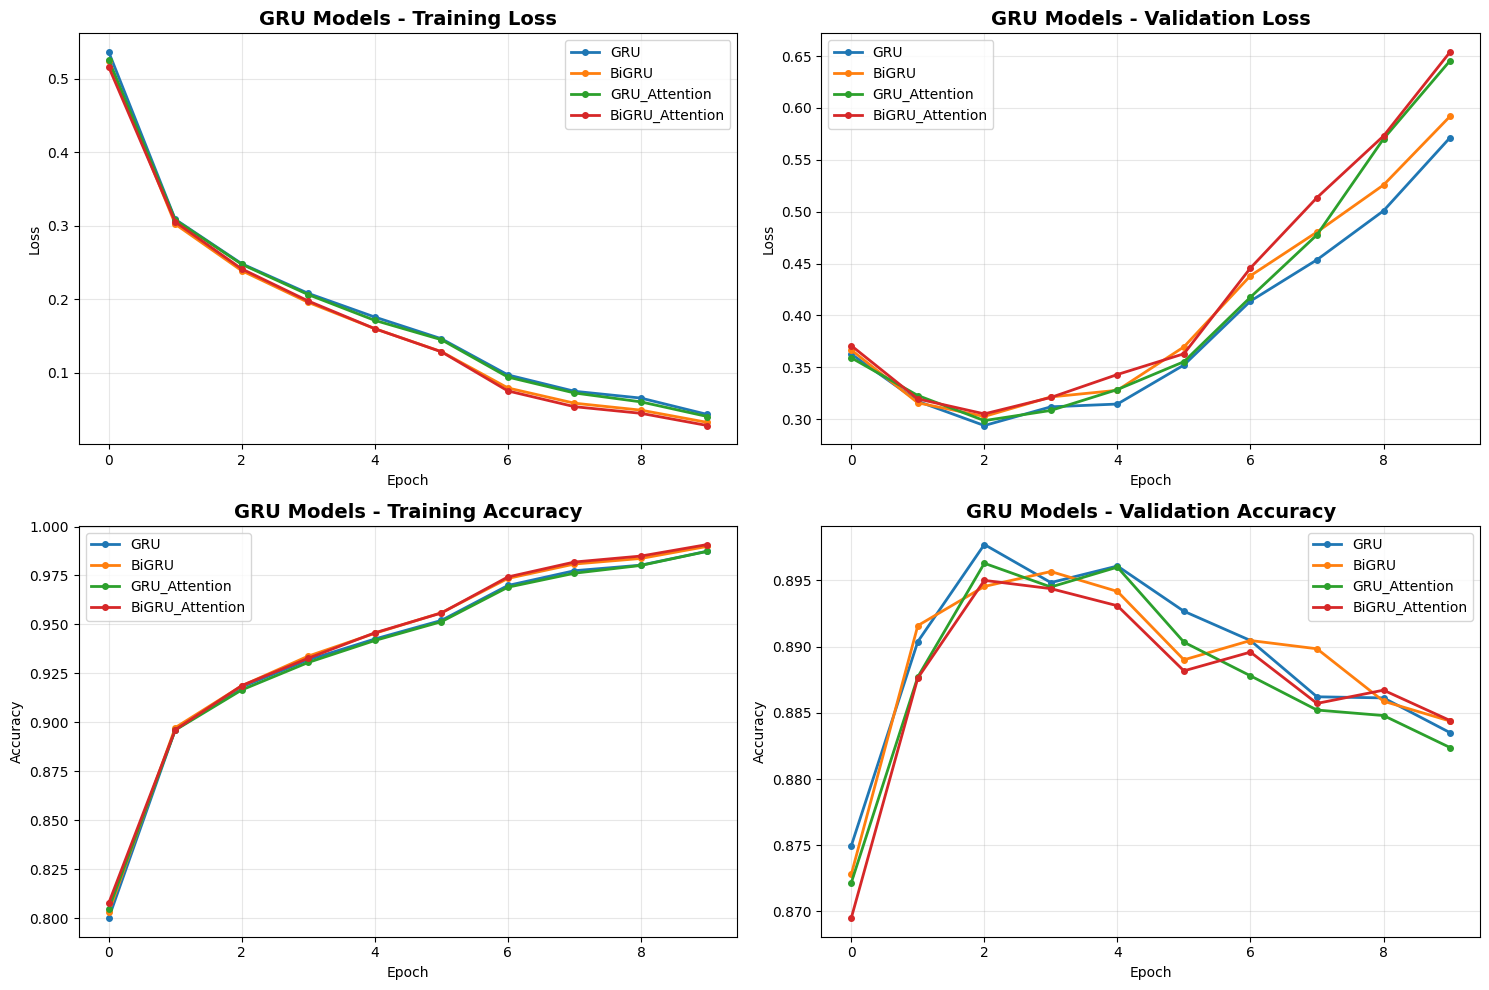


LSTM vs GRU Performance Comparison:
Model           LSTM         GRU          Difference  
--------------------------------------------------
LSTM            0.8888       0.8835       -0.0053
BiLSTM          0.8876       0.8844       -0.0032
Attention       0.8849       0.8824       -0.0025
BiAttention     0.8868       0.8844       -0.0024

Best GRU Model: BiGRU_Attention
Validation Accuracy: 0.8844

GRU models saved


In [ ]:
# Training GRU models with best hyperparameters - Optimized
print("Training GRU models...")

def train_gru_model(model, model_name, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    print(f"\n{'='*60}")
    print(f"Training {model_name}...")
    print(f"{'='*60}")

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

            if batch_idx % 10 == 0:
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_accuracy = train_correct / train_total
        val_accuracy = val_correct / val_total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

        scheduler.step(avg_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    final_val_acc = val_accs[-1]
    print(f"{model_name} training completed - Final Val Accuracy: {final_val_acc:.4f}")

    return {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs,
        'final_val_acc': final_val_acc
    }

# Train all GRU models with best hyperparameters
gru_results = {}

for model_name, model in gru_models_dict.items():
    history = train_gru_model(
        model, model_name, train_loader_tokens, val_loader_tokens,
        num_epochs=10, learning_rate=0.001
    )
    gru_results[model_name] = history

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Results comparison
print("\n" + "="*60)
print("GRU Model Comparison:")
print("="*60)
print(f"{'Model':<20} {'Val Accuracy':<15} {'Parameters':<12}")
print("-" * 50)
for model_name, history in gru_results.items():
    accuracy = history['final_val_acc']
    params = sum(p.numel() for p in gru_models_dict[model_name].parameters())
    print(f"{model_name:<20} {accuracy:<15.4f} {params:<12,}")

# Plot GRU training history
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
for model_name, history in gru_results.items():
    plt.plot(history['train_loss'], label=model_name, linewidth=2, marker='o', markersize=4)
plt.title('GRU Models - Training Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
for model_name, history in gru_results.items():
    plt.plot(history['val_loss'], label=model_name, linewidth=2, marker='o', markersize=4)
plt.title('GRU Models - Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
for model_name, history in gru_results.items():
    plt.plot(history['train_acc'], label=model_name, linewidth=2, marker='o', markersize=4)
plt.title('GRU Models - Training Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
for model_name, history in gru_results.items():
    plt.plot(history['val_acc'], label=model_name, linewidth=2, marker='o', markersize=4)
plt.title('GRU Models - Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# LSTM vs GRU comparison
print("\n" + "="*60)
print("LSTM vs GRU Performance Comparison:")
print("="*60)
lstm_gru_comparison = {
    'LSTM': (final_results['LSTM']['accuracy'], gru_results['GRU']['final_val_acc']),
    'BiLSTM': (final_results['BiLSTM']['accuracy'], gru_results['BiGRU']['final_val_acc']),
    'Attention': (final_results['LSTM_Attention']['accuracy'], gru_results['GRU_Attention']['final_val_acc']),
    'BiAttention': (final_results['BiLSTM_Attention']['accuracy'], gru_results['BiGRU_Attention']['final_val_acc']),
}

print(f"{'Model':<15} {'LSTM':<12} {'GRU':<12} {'Difference':<12}")
print("-" * 50)
for model_type, (lstm_acc, gru_acc) in lstm_gru_comparison.items():
    diff = gru_acc - lstm_acc
    print(f"{model_type:<15} {lstm_acc:<12.4f} {gru_acc:<12.4f} {diff:+.4f}")

# Best GRU model
best_gru_model = max(gru_results.items(), key=lambda x: x[1]['final_val_acc'])[0]
print(f"\n{'='*60}")
print(f"Best GRU Model: {best_gru_model}")
print(f"Validation Accuracy: {gru_results[best_gru_model]['final_val_acc']:.4f}")
print(f"{'='*60}")

# Save GRU models
for model_name, model in gru_models_dict.items():
    torch.save(model.state_dict(), f'gru_{model_name}_weights.pth')
print("\nGRU models saved")


####3.4 Analysis Questions (100 Marks)

1. Suppose the GRU and LSTM models achieve very similar accuracy on this dataset. Which would you recommend for deployment, and why?

If the GRU and LSTM models achieve very similar accuracy on this dataset, the GRU model is generally the better choice for deployment. This recommendation is based on several practical advantages:

Efficiency: GRUs have a simpler architecture with fewer gates and parameters than LSTMs. This makes them faster to train and more efficient during inference, which is especially important for production systems that need to process large volumes of data or operate under strict latency constraints.​

Lower Memory Usage: Because GRUs use fewer parameters, they consume less memory, making them more suitable for deployment on resource-constrained environments or when scaling up to serve many users simultaneously.​

Comparable Performance: When accuracy is similar, the extra complexity of LSTMs does not provide a meaningful benefit. GRUs are often able to match or even slightly outperform LSTMs on many text classification tasks, especially when long-term dependencies are not extremely critical.​

Simplicity: The simpler design of GRUs reduces the risk of overfitting and makes the model easier to maintain and debug in production.

In summary:
Choose GRU for deployment when both models perform similarly, as it offers faster computation, lower memory usage, and easier maintenance, all without sacrificing accuracy for most practical text classification tasks. LSTM should only be preferred if there is clear evidence that its more complex memory structure yields significantly better results for the specific application.

2. Why might GRUs be particularly suitable for shorter text sequences like news articles compared to LSTMs?

GRUs are particularly suitable for shorter text sequences like news articles because their simpler architecture allows them to efficiently capture the necessary dependencies without the overhead of managing long-term memory. GRUs use fewer gates than LSTMs, which means they require less computation and memory, making them faster to train and infer.​

For short or medium-length sequences, the advantage of LSTM’s more complex gating system—designed to retain information over long periods—is less relevant. News articles typically do not require modeling very long-range dependencies, so the streamlined design of GRUs is sufficient to capture the context and relationships needed for accurate classification. As a result, GRUs often match or outperform LSTMs on short texts, while being more efficient and easier to deploy in production environments.

3. In the `BiGRUClassifier`, why do we concatenate `hidden[-2,:,:]` and `hidden[-1,:,:]` before classification?

In the BiGRUClassifier, concatenating hidden[-2,:,:] and hidden[-1,:,:] before classification combines the final hidden states from both the forward and backward GRU layers. In a bidirectional GRU, the hidden state tensor contains the last hidden state for each direction: hidden[-2,:,:] corresponds to the last hidden state from the forward pass, and hidden[-1,:,:] corresponds to the last hidden state from the backward pass.​

By concatenating these two vectors, the model creates a comprehensive representation that captures information from both the past and future contexts in the input sequence. This enriched feature vector is then used for classification, allowing the model to make decisions based on the full context surrounding each token, rather than just the preceding or following words. This approach improves the model's ability to understand and classify sequences where meaning depends on both earlier and later parts of the text.In the BiGRUClassifier, concatenating hidden[-2,:,:] and hidden[-1,:,:] before classification is necessary because these represent the final hidden states from the forward and backward GRU passes, respectively. In a bidirectional GRU, the model processes the input sequence in both directions: one GRU runs from start to end (forward), and the other from end to start (backward). The last hidden state of the forward GRU (hidden[-2,:,:]) captures information from the beginning up to the end, while the last hidden state of the backward GRU (hidden[-1,:,:]) captures information from the end back to the beginning.​

By concatenating these two states, the classifier combines both perspectives, creating a richer representation that incorporates context from both directions. This allows the final classification layer to make decisions based on the entire sequence, leveraging information from both the past and future relative to each token, which is especially valuable for tasks where context on both sides of a word or phrase is important.

4. How does the attention mechanism work in the GRUAttentionClassifier? What problem does it solve compared to plain GRU?

How the Attention Mechanism Works in GRUAttentionClassifier
In the GRUAttentionClassifier, the attention mechanism operates by assigning a weight (or score) to each hidden state output from the GRU across the input sequence. After the GRU processes the sequence and produces a series of hidden states (one for each time step), the attention layer computes how important each hidden state is for the final classification. These attention scores are typically calculated using a small neural network (often a linear layer followed by a nonlinearity), which produces a probability distribution over the sequence positions.

The model then takes a weighted sum of all the hidden states, where the weights are the attention scores. This produces a single context vector that emphasizes the most relevant parts of the input sequence for the task at hand. The context vector is then passed to the final classification layer.

What Problem Does Attention Solve Compared to Plain GRU?
A plain GRU summarizes the entire sequence into its final hidden state, which can cause the model to lose important information, especially in long or information-dense sequences. This means the model might overlook key words or phrases that are crucial for classification, simply because they occurred earlier or later in the sequence and their influence faded as the GRU processed more tokens.

The attention mechanism solves this problem by allowing the model to "look back" at all positions in the sequence and explicitly focus on the most informative parts, regardless of their position. This selective focus helps the model capture context more effectively, improves performance on tasks where certain words are much more important than others, and makes the model more interpretable by showing which parts of the input influenced its decision most strongly.​



5. When comparing GRU-based models to LSTM-based models, what trade-offs should you consider for production deployment? (Think accuracy, speed, complexity, generalization.)

When deciding between GRU-based and LSTM-based models for production deployment, here’s how to think about the trade-offs in a practical, human way:

If both models are giving almost the same accuracy on your validation or test set, GRU is usually the smarter pick for real-world use. Why? GRUs are simpler—they have fewer gates and parameters, so they train faster and use less memory. This means your model will be quicker to deploy, easier to maintain, and cheaper to run, especially if you’re working with lots of data or need to serve predictions in real time.

LSTMs are a bit heavier and can sometimes capture longer-term patterns in really complex or lengthy sequences, but for most tasks like news or document classification, that extra complexity doesn’t translate into a big accuracy boost. In fact, the difference is often so small that it’s not worth the extra computational cost and potential for overfitting.

##Task 4 : CNN (600 Marks)

####  CNNs for Text: Finding Patterns, Not Sequences   

Wait… CNNs? Aren’t those for images?  
**Yes!** But here’s the insight: CNNs detect **local patterns**.  
- In images → edges and shapes  
- In text → n-grams and phrases  

---

#### The Fundamental Difference  

**RNNs (LSTM/GRU):**  
- Process text sequentially: word1 → word2 → word3  
- Maintain memory across the sequence  
- Good for: word order, long-range dependencies
- Slow: must process one word at a time  

**CNNs:**  
- Process text in parallel, scanning all n-grams simultaneously  
- Detect local patterns: “scored a goal”, “stock market”, “breaking news”  
- Good for: phrase detection, parallelism  
- Fast: processes the entire text at once  

**Analogy:**  
- RNN = reading a book, remembering context as you go  
- CNN = scanning for keywords, instantly spotting “goal” everywhere  

---

#### Why Multiple CNN Architectures?  


 **Hierarchical CNN**  
- Two-level architecture: **word → sentence → document**  
- First: understand each sentence  
- Then: combine sentences for document classification  
- Best for longer texts with clear sentence structure  

 **Strided CNN**  
- Uses stride to downsample (like ResNet in images)  
- Reduces computational cost  
- Multiple layers build hierarchical understanding  

**Multi-Channel CNN**  
- Two embedding channels: **static (frozen)** + **dynamic (trainable)**  
- Static preserves pre-trained knowledge  
- Dynamic adapts to the task  
- Inspired by [Kim (2014)](https://aclanthology.org/D14-1181.pdf) — very influential architecture  

 **Dynamic Pooling CNN**  
- Instead of global max pooling, splits into bins  
- Captures positional information (e.g., beginning vs. end of text)  
- More structured than a single global pooling step  

---

#### The Big Questions  

1. Can CNNs match RNNs for text classification?  
2. Is parallel processing faster than sequential?  
3. Do n-gram patterns matter more than word order for news?  
4. Which CNN architecture works best: simple or complex?  

#### Evaluate models using:

   * Accuracy, Precision, Recall, F1-score, ROC (AUC)
   * Confusion matrix (to see class-wise performance)
   * Training time and memory usage (since more complex models are costlier).

**Deliverables:**

* Code for all four models
* Training logs/plots (loss & accuracy curves)
* Accuracy, Precision, Recall, F1-score, ROC (AUC)
* Final comparison table of metrics
* Short reflection on the “accuracy vs. cost” trade-off
* Report

References :
- [Dive into CNN](https://www.d2l.ai/chapter_convolutional-modern/index.html)
- [NLP with CNNs](https://towardsdatascience.com/nlp-with-cnns-a6aa743bdc1e/)  

**You don't need to implement the CNN from scratch. You can use PyTorch to implement CNN, but make sure you clearly understand CNN's architecture and the underlying mathematical concepts.**

**Spoiler (from research):**  
For classification tasks, **CNNs often outperform RNNs while being much faster.**  

 Let’s test if “thinking in parallel” beats “thinking sequentially”!   


###4.1 Hierarchical CNN

####4.1.1 Custom Dataset Class that converts Documents into Hierarchical Sentence-Word Embedding Tensors


In [ ]:
# Hierarchical CNN Dataset Class
import torch
from torch.utils.data import Dataset
import numpy as np
import re

class HierarchicalTextDataset(Dataset):
    """
    PyTorch Dataset for hierarchical text data (documents -> sentences -> words).
    Converts each document into a fixed-size tensor using word embeddings.
    """
    def __init__(self, texts, labels, word_vectors,
                 max_sents=5, max_words=15, embedding_dim=100):
        """
        Args:
            texts         : List of documents (strings or preprocessed text)
            labels        : List of class labels for each document
            word_vectors  : Pre-trained word embedding model (e.g., GloVe, Word2Vec)
            max_sents     : Maximum number of sentences per document
            max_words     : Maximum number of words per sentence
            embedding_dim : Dimensionality of word embeddings
        """
        self.texts = texts.reset_index(drop=True) if hasattr(texts, 'reset_index') else texts
        self.labels = labels
        self.word_vectors = word_vectors
        self.max_sents = max_sents
        self.max_words = max_words
        self.embedding_dim = embedding_dim
        self.zero_vector = np.zeros(embedding_dim, dtype=np.float32)

    def split_into_sentences(self, text):
        """
        Splits text into sentences using basic punctuation.
        """
        sentences = re.split(r'[.!?]+', text)
        sentences = [s.strip() for s in sentences if s.strip()]
        return sentences[:self.max_sents]

    def __len__(self):
        """
        Returns:
            Total number of documents in the dataset
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Converts the document at index idx into a hierarchical tensor.

        Args:
            idx : Index of document to retrieve

        Returns:
            tuple:
                tensor_doc : (max_sents, max_words, embedding_dim) tensor representation
                label      : Corresponding class label
        """
        text = self.texts.iloc[idx] if hasattr(self.texts, 'iloc') else self.texts[idx]
        label = self.labels[idx]

        # Split document into sentences
        sentences = self.split_into_sentences(text)

        # Pre-allocate tensor for document
        doc_tensor = np.zeros((self.max_sents, self.max_words, self.embedding_dim), dtype=np.float32)

        # Process each sentence
        for s_idx, sentence in enumerate(sentences):
            if s_idx >= self.max_sents:
                break

            # Split sentence into words
            words = sentence.split()[:self.max_words]

            # Get embeddings for each word
            for w_idx, word in enumerate(words):
                if w_idx >= self.max_words:
                    break

                if word in self.word_vectors.key_to_index:
                    doc_tensor[s_idx, w_idx] = self.word_vectors[word].astype(np.float32)

        # Convert to PyTorch tensor
        tensor_doc = torch.from_numpy(doc_tensor)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return tensor_doc, label_tensor

print("HierarchicalTextDataset class defined")


HierarchicalTextDataset class defined


####4.1.2 Custom Model Class for Implementing Hierarchical CNN

In [ ]:
# Hierarchical CNN Model
import torch.nn as nn
import torch.nn.functional as F

class HierarchicalCNN(nn.Module):
    """
    Hierarchical CNN for document classification.
    Combines word-level and sentence-level CNNs to learn multi-level features.
    """
    def __init__(self, embedding_dim, num_classes,
                 num_filters=100, filter_sizes=(3,4,5),
                 max_words=20, dropout=0.5):
        """
        Args:
            embedding_dim : Dimensionality of word embeddings
            num_classes   : Number of output classes
            num_filters   : Filters per convolution layer
            filter_sizes  : List of filter sizes (kernel heights)
            max_words     : Max words per sentence
            dropout       : Dropout probability
        """
        super(HierarchicalCNN, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_filters = num_filters
        self.filter_sizes = filter_sizes
        self.max_words = max_words

        # Word-level CNN: processes each sentence independently
        self.word_convs = nn.ModuleList([
            nn.Conv2d(in_channels=1,
                     out_channels=num_filters,
                     kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])

        # Sentence-level CNN: processes sentence representations
        sentence_input_dim = num_filters * len(filter_sizes)
        self.sentence_conv = nn.Conv1d(in_channels=sentence_input_dim,
                                       out_channels=num_filters,
                                       kernel_size=3,
                                       padding=1)

        # Dropout layers
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer for classification
        self.fc = nn.Linear(num_filters, num_classes)

    def forward(self, x):
        """
        Forward pass through hierarchical CNN.

        Args:
            x : Tensor of shape (batch, max_sents, max_words, embed_dim)

        Returns:
            out : Logits tensor of shape (batch, num_classes)
        """
        batch_size, max_sents, max_words, embed_dim = x.shape

        # Reshape to process all sentences together
        x_flat = x.view(batch_size * max_sents, max_words, embed_dim)

        # Add channel dimension for Conv2d
        x_flat = x_flat.unsqueeze(1)

        # Word-level convolutions
        word_features = []
        for conv in self.word_convs:
            # Apply convolution
            conv_out = F.relu(conv(x_flat))

            # Max pooling over sequence
            pooled = F.max_pool2d(conv_out, kernel_size=(conv_out.size(2), 1))

            # Flatten
            pooled = pooled.squeeze(-1).squeeze(-1)
            word_features.append(pooled)

        # Concatenate features from different filter sizes
        word_features = torch.cat(word_features, dim=1)

        # Reshape back to sentence structure
        sentence_repr = word_features.view(batch_size, max_sents, -1)

        # Transpose for Conv1d
        sentence_repr = sentence_repr.transpose(1, 2)

        # Sentence-level convolution
        sent_conv = F.relu(self.sentence_conv(sentence_repr))

        # Global max pooling over sentences
        doc_repr = F.max_pool1d(sent_conv, kernel_size=sent_conv.size(2)).squeeze(-1)

        # Apply dropout
        doc_repr = self.dropout(doc_repr)

        # Classification
        out = self.fc(doc_repr)

        return out

print("HierarchicalCNN class defined")


HierarchicalCNN class defined


####4.1.3  Document to Tensor Conversion

In [ ]:
# Document to Tensor Conversion
import numpy as np
import re

def doc_to_tensor(doc, word_vectors, max_sents=10, max_words=20, embedding_dim=100):
    """
    Convert a document into a fixed-size tensor.

    Args:
        doc           : Raw document text (string)
        word_vectors  : Pre-trained embedding dictionary/model
        max_sents     : Maximum sentences per document
        max_words     : Maximum words per sentence
        embedding_dim : Embedding dimensionality

    Returns:
        np.array : Tensor of shape (max_sents, max_words, embedding_dim)
    """
    # Initialize tensor with zeros
    tensor = np.zeros((max_sents, max_words, embedding_dim), dtype=np.float32)

    # Split document into sentences
    sentences = re.split(r'[.!?]+', doc)
    sentences = [s.strip() for s in sentences if s.strip()]

    # Process each sentence
    for sent_idx, sentence in enumerate(sentences[:max_sents]):
        # Split sentence into words
        words = sentence.split()[:max_words]

        # Get embedding for each word
        for word_idx, word in enumerate(words):
            if word in word_vectors.key_to_index:
                tensor[sent_idx, word_idx] = word_vectors[word].astype(np.float32)

    return tensor

print("doc_to_tensor function defined")


doc_to_tensor function defined


####4.1.4 Data Preparation for hCNN Model


In [ ]:
# Data Preparation for Hierarchical CNN Model
print("Preparing data for Hierarchical CNN...")

# Hyperparameters for hierarchical structure
max_sents_hcnn = 10
max_words_hcnn = 20
embedding_dim_hcnn = word_vectors.vector_size

print(f"Hierarchical CNN parameters:")
print(f"  Max sentences per document: {max_sents_hcnn}")
print(f"  Max words per sentence: {max_words_hcnn}")
print(f"  Embedding dimension: {embedding_dim_hcnn}")

# Create hierarchical datasets
print("\nCreating hierarchical datasets...")
hcnn_train_dataset = HierarchicalTextDataset(
    texts=X_train_processed,
    labels=y_train_encoded,
    word_vectors=word_vectors,
    max_sents=max_sents_hcnn,
    max_words=max_words_hcnn,
    embedding_dim=embedding_dim_hcnn
)

hcnn_test_dataset = HierarchicalTextDataset(
    texts=X_test_processed,
    labels=y_test_encoded,
    word_vectors=word_vectors,
    max_sents=max_sents_hcnn,
    max_words=max_words_hcnn,
    embedding_dim=embedding_dim_hcnn
)

# Split train into train and validation
from torch.utils.data import random_split

train_size_hcnn = int(0.8 * len(hcnn_train_dataset))
val_size_hcnn = len(hcnn_train_dataset) - train_size_hcnn

hcnn_train_split, hcnn_val_split = random_split(
    hcnn_train_dataset,
    [train_size_hcnn, val_size_hcnn],
    generator=torch.Generator().manual_seed(42)
)

print(f"Training samples: {len(hcnn_train_split)}")
print(f"Validation samples: {len(hcnn_val_split)}")
print(f"Test samples: {len(hcnn_test_dataset)}")

# Create dataloaders
batch_size_hcnn = 32
num_workers_hcnn = 2 if device.type == 'cpu' else 4
pin_memory_hcnn = torch.cuda.is_available()

hcnn_train_loader = DataLoader(
    hcnn_train_split,
    batch_size=batch_size_hcnn,
    shuffle=True,
    num_workers=num_workers_hcnn,
    pin_memory=pin_memory_hcnn,
    persistent_workers=True if num_workers_hcnn > 0 else False
)

hcnn_val_loader = DataLoader(
    hcnn_val_split,
    batch_size=batch_size_hcnn,
    shuffle=False,
    num_workers=num_workers_hcnn,
    pin_memory=pin_memory_hcnn,
    persistent_workers=True if num_workers_hcnn > 0 else False
)

hcnn_test_loader = DataLoader(
    hcnn_test_dataset,
    batch_size=batch_size_hcnn,
    shuffle=False,
    num_workers=num_workers_hcnn,
    pin_memory=pin_memory_hcnn,
    persistent_workers=True if num_workers_hcnn > 0 else False
)

print(f"\nDataLoaders created:")
print(f"  Training batches: {len(hcnn_train_loader)}")
print(f"  Validation batches: {len(hcnn_val_loader)}")
print(f"  Test batches: {len(hcnn_test_loader)}")
print(f"  Batch size: {batch_size_hcnn}")

# Test one batch
print("\nTesting batch loading...")
for batch_idx, (data, targets) in enumerate(hcnn_train_loader):
    print(f"Batch shape: {data.shape}")
    print(f"Expected shape: (batch_size, max_sents, max_words, embedding_dim)")
    print(f"Targets shape: {targets.shape}")
    print(f"Sample targets: {targets[:5].tolist()}")
    break

print("\nHierarchical CNN data preparation complete")


Preparing data for Hierarchical CNN...
Hierarchical CNN parameters:
  Max sentences per document: 10
  Max words per sentence: 20
  Embedding dimension: 100

Creating hierarchical datasets...
Training samples: 96000
Validation samples: 24000
Test samples: 7600

DataLoaders created:
  Training batches: 3000
  Validation batches: 750
  Test batches: 238
  Batch size: 32

Testing batch loading...
Batch shape: torch.Size([32, 10, 20, 100])
Expected shape: (batch_size, max_sents, max_words, embedding_dim)
Targets shape: torch.Size([32])
Sample targets: [2, 0, 1, 3, 0]

Hierarchical CNN data preparation complete


####4.1.5 Model Initialization

In [ ]:
# Model Initialization for Hierarchical CNN
print("Initializing Hierarchical CNN model...")

# Use the same max_words and max_sents from data preparation
max_words = max_words_hcnn
max_sents = max_sents_hcnn

# Model hyperparameters
num_filters_hcnn = 128
filter_sizes_hcnn = (3, 4, 5)
dropout_hcnn = 0.5

# Initialize Hierarchical CNN
hcnn_model = HierarchicalCNN(
    embedding_dim=embedding_dim,
    num_classes=num_classes,
    num_filters=num_filters_hcnn,
    filter_sizes=filter_sizes_hcnn,
    max_words=max_words,
    dropout=dropout_hcnn
).to(device)

# Count parameters
total_params = sum(p.numel() for p in hcnn_model.parameters())
trainable_params = sum(p.numel() for p in hcnn_model.parameters() if p.requires_grad)

print(f"\nModel architecture:")
print(f"  Embedding dimension: {embedding_dim}")
print(f"  Number of classes: {num_classes}")
print(f"  Number of filters: {num_filters_hcnn}")
print(f"  Filter sizes: {filter_sizes_hcnn}")
print(f"  Max sentences per document: {max_sents}")
print(f"  Max words per sentence: {max_words}")
print(f"  Dropout rate: {dropout_hcnn}")
print(f"\nModel parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

# Optimizer and loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(hcnn_model.parameters(), lr=0.001, weight_decay=1e-5)

print(f"\nOptimizer: Adam")
print(f"  Learning rate: 0.001")
print(f"  Weight decay: 1e-5")
print(f"\nLoss function: CrossEntropyLoss")

print("\nHierarchical CNN model initialization complete")


Initializing Hierarchical CNN model...

Model architecture:
  Embedding dimension: 100
  Number of classes: 4
  Number of filters: 128
  Filter sizes: (3, 4, 5)
  Max sentences per document: 10
  Max words per sentence: 20
  Dropout rate: 0.5

Model parameters:
  Total: 302,084
  Trainable: 302,084

Optimizer: Adam
  Learning rate: 0.001
  Weight decay: 1e-5

Loss function: CrossEntropyLoss

Hierarchical CNN model initialization complete


####4.1.6 Training and Evaluation

In [ ]:
# Training and Evaluation for Hierarchical CNN
import torch.optim as optim
from tqdm import tqdm
import gc

print("Defining CNN training and evaluation functions...")

def train_cnn_model(model, train_loader, val_loader, criterion, optimizer,
                    num_epochs=5, model_name="CNN"):
    """
    Training function for CNN models with validation.
    """
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2
    )

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

            if batch_idx % 10 == 0:
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_accuracy = train_correct / train_total
        val_accuracy = val_correct / val_total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(avg_val_loss)
        new_lr = optimizer.param_groups[0]['lr']

        if new_lr != old_lr:
            print(f"Learning rate reduced: {old_lr:.6f} -> {new_lr:.6f}")

        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print(f"\n{model_name} training completed")
    print(f"Final validation accuracy: {val_accs[-1]:.4f}")

    return {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs,
        'final_val_acc': val_accs[-1]
    }

def evaluate_cnn_model(model, test_loader, criterion):
    """
    Evaluation function for CNN models on test set.
    """
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Evaluating')
        for data, target in pbar:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            output = model(data)
            loss = criterion(output, target)

            test_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            all_predictions.append(predicted.cpu().numpy())
            all_labels.append(target.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct / total

    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)

    print(f'\nTest Results:')
    print(f'  Loss: {avg_test_loss:.4f}')
    print(f'  Accuracy: {test_accuracy:.4f}')

    return {
        'loss': avg_test_loss,
        'accuracy': test_accuracy,
        'predictions': all_predictions,
        'labels': all_labels
    }

print("Functions defined. Starting training...\n")

# Training Hierarchical CNN
print("Training Hierarchical CNN model...")
print(f"Using dataloaders from data preparation:")
print(f"  Training batches: {len(hcnn_train_loader)}")
print(f"  Validation batches: {len(hcnn_val_loader)}")
print(f"  Test batches: {len(hcnn_test_loader)}")

# Train the model
hcnn_history = train_cnn_model(
    model=hcnn_model,
    train_loader=hcnn_train_loader,
    val_loader=hcnn_val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=5,
    model_name="Hierarchical CNN"
)

# Evaluate on test set
hcnn_test_results = evaluate_cnn_model(
    model=hcnn_model,
    test_loader=hcnn_test_loader,
    criterion=criterion
)

# Save model
torch.save(hcnn_model.state_dict(), 'hierarchical_cnn_weights.pth')
print("\nModel saved: hierarchical_cnn_weights.pth")

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()


Defining CNN training and evaluation functions...
Functions defined. Starting training...

Training Hierarchical CNN model...
Using dataloaders from data preparation:
  Training batches: 3000
  Validation batches: 750
  Test batches: 238

Training Hierarchical CNN


Epoch 1/10: 100%|██████████| 3000/3000 [15:09<00:00,  3.30it/s, loss=0.5438]


Epoch 1/10: Train Loss: 0.3734, Train Acc: 0.8752 | Val Loss: 0.3231, Val Acc: 0.8843


Epoch 2/10: 100%|██████████| 3000/3000 [15:09<00:00,  3.30it/s, loss=0.1482]


Epoch 2/10: Train Loss: 0.2976, Train Acc: 0.9002 | Val Loss: 0.3187, Val Acc: 0.8917


Epoch 3/10: 100%|██████████| 3000/3000 [15:09<00:00,  3.30it/s, loss=0.2531]


Epoch 3/10: Train Loss: 0.2504, Train Acc: 0.9142 | Val Loss: 0.3124, Val Acc: 0.8967


Epoch 4/10: 100%|██████████| 3000/3000 [15:09<00:00,  3.30it/s, loss=0.2361]


Epoch 4/10: Train Loss: 0.2100, Train Acc: 0.9265 | Val Loss: 0.3326, Val Acc: 0.8960


Epoch 5/10: 100%|██████████| 3000/3000 [15:09<00:00,  3.30it/s, loss=0.4662]


Epoch 5/10: Train Loss: 0.1792, Train Acc: 0.9362 | Val Loss: 0.3620, Val Acc: 0.8923


Epoch 6/10: 100%|██████████| 3000/3000 [15:09<00:00,  3.30it/s, loss=0.1253]


Learning rate reduced: 0.001000 -> 0.000500
Epoch 6/10: Train Loss: 0.1525, Train Acc: 0.9443 | Val Loss: 0.4046, Val Acc: 0.8945


Epoch 7/10: 100%|██████████| 3000/3000 [15:09<00:00,  3.30it/s, loss=0.1086]


Epoch 7/10: Train Loss: 0.0941, Train Acc: 0.9652 | Val Loss: 0.5650, Val Acc: 0.8930


Epoch 8/10: 100%|██████████| 3000/3000 [15:09<00:00,  3.30it/s, loss=0.1056]


Epoch 8/10: Train Loss: 0.0704, Train Acc: 0.9745 | Val Loss: 0.6145, Val Acc: 0.8893


Epoch 9/10: 100%|██████████| 3000/3000 [15:09<00:00,  3.30it/s, loss=0.0339]


Learning rate reduced: 0.000500 -> 0.000250
Epoch 9/10: Train Loss: 0.0577, Train Acc: 0.9795 | Val Loss: 0.7669, Val Acc: 0.8880


Epoch 10/10: 100%|██████████| 3000/3000 [15:09<00:00,  3.30it/s, loss=0.0167]


Epoch 10/10: Train Loss: 0.0363, Train Acc: 0.9872 | Val Loss: 0.8379, Val Acc: 0.8896

Hierarchical CNN training completed
Final validation accuracy: 0.8896


Evaluating: 100%|██████████| 238/238 [00:33<00:00,  7.15it/s]



Test Results:
  Loss: 0.8725
  Accuracy: 0.8921

Model saved: hierarchical_cnn_weights.pth


###4.2 Strided CNN

####4.2.1 Custom Model Class for Strided CNN

In [ ]:
# Strided CNN Model
import torch.nn as nn
import torch.nn.functional as F

class StridedCNN(nn.Module):
    """
    Strided Convolutional Neural Network for text classification.

    This architecture uses 1D convolutions with strides to progressively
    downsample the sequence dimension, capturing hierarchical local features
    and reducing sequence length before applying global pooling.
    """
    def __init__(self, input_dim, num_classes,
                 num_filters=128, kernel_size=5, stride=2, dropout=0.5):
        """
        Args:
            input_dim   : Dimensionality of input embeddings (e.g., 100)
            num_classes : Number of output categories
            num_filters : Number of convolution filters in the first layer
            kernel_size : Size of convolution kernels along the sequence dimension
            stride      : Stride for convolution (controls downsampling)
            dropout     : Dropout probability before classification
        """
        super(StridedCNN, self).__init__()

        self.input_dim = input_dim
        self.num_classes = num_classes

        # First strided convolution layer
        self.conv1 = nn.Conv1d(
            in_channels=input_dim,
            out_channels=num_filters,
            kernel_size=kernel_size,
            stride=stride,
            padding=kernel_size // 2
        )
        self.bn1 = nn.BatchNorm1d(num_filters)

        # Second strided convolution layer
        self.conv2 = nn.Conv1d(
            in_channels=num_filters,
            out_channels=num_filters * 2,
            kernel_size=kernel_size,
            stride=stride,
            padding=kernel_size // 2
        )
        self.bn2 = nn.BatchNorm1d(num_filters * 2)

        # Third strided convolution layer
        self.conv3 = nn.Conv1d(
            in_channels=num_filters * 2,
            out_channels=num_filters * 4,
            kernel_size=kernel_size,
            stride=stride,
            padding=kernel_size // 2
        )
        self.bn3 = nn.BatchNorm1d(num_filters * 4)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected classification layer
        self.fc = nn.Linear(num_filters * 4, num_classes)

    def forward(self, x):
        """
        Forward pass through the StridedCNN.

        Args:
            x : Tensor of shape (batch_size, seq_len, embedding_dim)
                representing a batch of embedded text sequences

        Returns:
            out : Logits tensor of shape (batch_size, num_classes)
        """
        # Transpose for Conv1d: (batch, seq_len, embedding_dim) -> (batch, embedding_dim, seq_len)
        x = x.transpose(1, 2)

        # First convolution block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        # Second convolution block
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        # Third convolution block
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        # Global max pooling over the sequence dimension
        x = F.adaptive_max_pool1d(x, 1).squeeze(-1)

        # Dropout and classification
        x = self.dropout(x)
        out = self.fc(x)

        return out

print("StridedCNN class defined")


StridedCNN class defined


####4.2.2 Model Initialization

In [ ]:
# Model Initialization for Strided CNN
print("Initializing Strided CNN model...")

# Model hyperparameters
num_filters_strided = 128
kernel_size_strided = 5
stride_strided = 2
dropout_strided = 0.5

# Initialize model
strided_model = StridedCNN(
    input_dim=embedding_dim,
    num_classes=num_classes,
    num_filters=num_filters_strided,
    kernel_size=kernel_size_strided,
    stride=stride_strided,
    dropout=dropout_strided
).to(device)

# Count parameters
total_params = sum(p.numel() for p in strided_model.parameters())
trainable_params = sum(p.numel() for p in strided_model.parameters() if p.requires_grad)

print(f"\nModel architecture:")
print(f"  Input dimension: {embedding_dim}")
print(f"  Number of classes: {num_classes}")
print(f"  Number of filters: {num_filters_strided}")
print(f"  Kernel size: {kernel_size_strided}")
print(f"  Stride: {stride_strided}")
print(f"  Dropout rate: {dropout_strided}")
print(f"\nModel parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

# Optimizer and loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(strided_model.parameters(), lr=0.001, weight_decay=1e-5)

print(f"\nOptimizer: Adam")
print(f"  Learning rate: 0.001")
print(f"  Weight decay: 1e-5")
print(f"\nLoss function: CrossEntropyLoss")

print("\nStrided CNN model initialization complete")


Initializing Strided CNN model...

Model architecture:
  Input dimension: 100
  Number of classes: 4
  Number of filters: 128
  Kernel size: 5
  Stride: 2
  Dropout rate: 0.5

Model parameters:
  Total: 887,940
  Trainable: 887,940

Optimizer: Adam
  Learning rate: 0.001
  Weight decay: 1e-5

Loss function: CrossEntropyLoss

Strided CNN model initialization complete


####4.2.3 Training and Evaluation

In [ ]:
# Training and Evaluation for Strided CNN
import torch.optim as optim
from tqdm import tqdm
import gc

print("Preparing data for Strided CNN...")

# Create a simple dataset wrapper that reshapes data for CNN input
class CNNDataset(Dataset):
    """
    Wrapper dataset for CNN models that need (batch, seq_len, embed_dim) input.
    Uses pre-trained embeddings to convert token sequences to embedding sequences.
    """
    def __init__(self, token_dataset, embedding_matrix):
        self.token_dataset = token_dataset
        self.embedding_matrix = embedding_matrix

    def __len__(self):
        return len(self.token_dataset)

    def __getitem__(self, idx):
        tokens, label = self.token_dataset[idx]
        # Convert tokens to embeddings
        embeddings = self.embedding_matrix[tokens]
        return embeddings, label

# Create embedding matrix from tokenizer vocabulary
print("Creating embedding matrix...")
embedding_matrix_strided = np.zeros((vocab_size, embedding_dim), dtype=np.float32)

for word, idx in tokenizer.word_index.items():
    if idx >= vocab_size:
        break
    if word in word_vectors.key_to_index:
        embedding_matrix_strided[idx] = word_vectors[word].astype(np.float32)

embedding_matrix_strided = torch.from_numpy(embedding_matrix_strided)

print(f"Embedding matrix shape: {embedding_matrix_strided.shape}")

# Create CNN datasets using embedding matrix
strided_train_dataset = CNNDataset(train_split, embedding_matrix_strided)
strided_val_dataset = CNNDataset(val_split, embedding_matrix_strided)
strided_test_dataset = CNNDataset(test_dataset_tokens, embedding_matrix_strided)

# Create dataloaders
strided_train_loader = DataLoader(
    strided_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=True if num_workers > 0 else False
)

strided_val_loader = DataLoader(
    strided_val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=True if num_workers > 0 else False
)

strided_test_loader = DataLoader(
    strided_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=True if num_workers > 0 else False
)

print(f"\nDataLoaders created:")
print(f"  Training batches: {len(strided_train_loader)}")
print(f"  Validation batches: {len(strided_val_loader)}")
print(f"  Test batches: {len(strided_test_loader)}")

# Define training and evaluation functions if not already defined
def train_cnn_model(model, train_loader, val_loader, criterion, optimizer,
                    num_epochs=5, model_name="CNN"):
    """
    Training function for CNN models with validation.
    """
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2
    )

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

            if batch_idx % 10 == 0:
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_accuracy = train_correct / train_total
        val_accuracy = val_correct / val_total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(avg_val_loss)
        new_lr = optimizer.param_groups[0]['lr']

        if new_lr != old_lr:
            print(f"Learning rate reduced: {old_lr:.6f} -> {new_lr:.6f}")

        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print(f"\n{model_name} training completed")
    print(f"Final validation accuracy: {val_accs[-1]:.4f}")

    return {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs,
        'final_val_acc': val_accs[-1]
    }

def evaluate_cnn_model(model, test_loader, criterion):
    """
    Evaluation function for CNN models on test set.
    """
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Evaluating')
        for data, target in pbar:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            output = model(data)
            loss = criterion(output, target)

            test_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            all_predictions.append(predicted.cpu().numpy())
            all_labels.append(target.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct / total

    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)

    print(f'\nTest Results:')
    print(f'  Loss: {avg_test_loss:.4f}')
    print(f'  Accuracy: {test_accuracy:.4f}')

    return {
        'loss': avg_test_loss,
        'accuracy': test_accuracy,
        'predictions': all_predictions,
        'labels': all_labels
    }

# Train the model
print("\nTraining Strided CNN model...")
strided_history = train_cnn_model(
    model=strided_model,
    train_loader=strided_train_loader,
    val_loader=strided_val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    model_name="Strided CNN"
)

# Evaluate on test set
strided_test_results = evaluate_cnn_model(
    model=strided_model,
    test_loader=strided_test_loader,
    criterion=criterion
)

# Save model
torch.save(strided_model.state_dict(), 'strided_cnn_weights.pth')
print("\nModel saved: strided_cnn_weights.pth")

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()


Preparing data for Strided CNN...
Creating embedding matrix...
Embedding matrix shape: torch.Size([83415, 100])

DataLoaders created:
  Training batches: 1500
  Validation batches: 375
  Test batches: 119

Training Strided CNN model...

Training Strided CNN


Epoch 1/10: 100%|██████████| 1500/1500 [00:13<00:00, 107.43it/s, loss=0.5398]


Epoch 1/10: Train Loss: 0.3902, Train Acc: 0.8694 | Val Loss: 0.3359, Val Acc: 0.8874


Epoch 2/10: 100%|██████████| 1500/1500 [00:13<00:00, 109.13it/s, loss=0.3259]


Epoch 2/10: Train Loss: 0.3201, Train Acc: 0.8918 | Val Loss: 0.3181, Val Acc: 0.8882


Epoch 3/10: 100%|██████████| 1500/1500 [00:13<00:00, 110.42it/s, loss=0.2494]


Epoch 3/10: Train Loss: 0.2820, Train Acc: 0.9028 | Val Loss: 0.3205, Val Acc: 0.8885


Epoch 4/10: 100%|██████████| 1500/1500 [00:13<00:00, 110.39it/s, loss=0.3745]


Epoch 4/10: Train Loss: 0.2498, Train Acc: 0.9134 | Val Loss: 0.3343, Val Acc: 0.8879


Epoch 5/10: 100%|██████████| 1500/1500 [00:13<00:00, 110.64it/s, loss=0.1513]


Learning rate reduced: 0.001000 -> 0.000500
Epoch 5/10: Train Loss: 0.2141, Train Acc: 0.9247 | Val Loss: 0.3224, Val Acc: 0.8913


Epoch 6/10: 100%|██████████| 1500/1500 [00:13<00:00, 110.13it/s, loss=0.1086]


Epoch 6/10: Train Loss: 0.1482, Train Acc: 0.9472 | Val Loss: 0.3651, Val Acc: 0.8908


Epoch 7/10: 100%|██████████| 1500/1500 [00:13<00:00, 109.96it/s, loss=0.0847]


Epoch 7/10: Train Loss: 0.1123, Train Acc: 0.9601 | Val Loss: 0.4480, Val Acc: 0.8869


Epoch 8/10: 100%|██████████| 1500/1500 [00:13<00:00, 110.16it/s, loss=0.1436]


Learning rate reduced: 0.000500 -> 0.000250
Epoch 8/10: Train Loss: 0.0887, Train Acc: 0.9678 | Val Loss: 0.5319, Val Acc: 0.8830


Epoch 9/10: 100%|██████████| 1500/1500 [00:13<00:00, 110.79it/s, loss=0.0543]


Epoch 9/10: Train Loss: 0.0510, Train Acc: 0.9820 | Val Loss: 0.6604, Val Acc: 0.8815


Epoch 10/10: 100%|██████████| 1500/1500 [00:13<00:00, 110.76it/s, loss=0.0294]


Epoch 10/10: Train Loss: 0.0354, Train Acc: 0.9877 | Val Loss: 0.8155, Val Acc: 0.8814

Strided CNN training completed
Final validation accuracy: 0.8814


Evaluating: 100%|██████████| 119/119 [00:00<00:00, 167.93it/s]



Test Results:
  Loss: 0.8104
  Accuracy: 0.8857

Model saved: strided_cnn_weights.pth


###4.3 Multi-Channel CNN

####4.3.1 Custom Dataset Class that Converts Text into Fixed-Length Token ID Sequences

In [ ]:
# Multi-Channel CNN Dataset Class
import torch
from torch.utils.data import Dataset
import numpy as np

class TokenIDDataset(Dataset):
    """
    PyTorch Dataset for token ID sequences.
    Converts text documents into padded sequences of token indices.
    """
    def __init__(self, texts, labels, vocab, max_len=100):
        """
        Args:
            texts   : List of text strings or pandas Series
            labels  : List or array of class labels
            vocab   : Dictionary mapping tokens to integer IDs
            max_len : Maximum sequence length (padding/truncation)
        """
        self.texts = texts.reset_index(drop=True) if hasattr(texts, 'reset_index') else texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def text_to_ids(self, text):
        """
        Convert text string to padded sequence of token IDs.
        """
        tokens = text.split()[:self.max_len]
        token_ids = [self.vocab.get(token, 0) for token in tokens]

        # Pad sequence
        if len(token_ids) < self.max_len:
            token_ids += [0] * (self.max_len - len(token_ids))

        return token_ids

    def __len__(self):
        """
        Returns:
            Total number of samples in the dataset
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Retrieve token ID sequence and corresponding label.

        Args:
            idx : Index of the data point

        Returns:
            tuple: (token_id_sequence, label)
        """
        text = self.texts.iloc[idx] if hasattr(self.texts, 'iloc') else self.texts[idx]
        label = self.labels[idx]

        token_ids = self.text_to_ids(text)

        token_ids_tensor = torch.tensor(token_ids, dtype=torch.long)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return token_ids_tensor, label_tensor

print("TokenIDDataset class defined")


TokenIDDataset class defined


####4.3.2 Custom Model Class for Implementing Multi-Channel CNN

In [ ]:
# Multi-Channel CNN Model
import torch.nn as nn
import torch.nn.functional as F

class MultiChannelCNN(nn.Module):
    """
    Multi-Channel Convolutional Neural Network for Text Classification.
    Uses two embedding channels:
        - Static channel: frozen embeddings
        - Dynamic channel: trainable embeddings
    Features from both channels are combined via convolution, pooling,
    and fully connected layers for classification.
    """
    def __init__(self, vocab_size, embedding_dim, num_classes,
                 num_filters=100, filter_sizes=(3,4,5), dropout=0.5,
                 pretrained_weights=None, freeze_static=True):
        """
        Args:
            vocab_size         : Size of vocabulary
            embedding_dim      : Dimensionality of embeddings
            num_classes        : Number of output classes
            num_filters        : Filters per convolution layer
            filter_sizes       : List of kernel sizes for convolution
            dropout            : Dropout probability
            pretrained_weights : Pre-trained embedding matrix (optional)
            freeze_static      : Whether to freeze static embedding weights
        """
        super(MultiChannelCNN, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_filters = num_filters
        self.filter_sizes = filter_sizes

        # Static embedding channel (frozen)
        self.static_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if pretrained_weights is not None:
            self.static_embedding.weight.data.copy_(pretrained_weights)
        if freeze_static:
            self.static_embedding.weight.requires_grad = False

        # Dynamic embedding channel (trainable)
        self.dynamic_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if pretrained_weights is not None:
            self.dynamic_embedding.weight.data.copy_(pretrained_weights)

        # Convolution layers for each filter size
        # Each processes concatenated static + dynamic embeddings (2 channels)
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=2,
                     out_channels=num_filters,
                     kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)

    def forward(self, x):
        """
        Forward pass for Multi-Channel CNN.

        Args:
            x : Tensor of token IDs, shape (batch_size, seq_len)

        Returns:
            out : Logits tensor of shape (batch_size, num_classes)
        """
        # Get embeddings from both channels
        # (batch_size, seq_len, embedding_dim)
        static_embed = self.static_embedding(x)
        dynamic_embed = self.dynamic_embedding(x)

        # Stack embeddings to create 2-channel input
        # (batch_size, 2, seq_len, embedding_dim)
        embedded = torch.stack([static_embed, dynamic_embed], dim=1)

        # Apply convolutions with different filter sizes
        conv_outputs = []
        for conv in self.convs:
            # Apply convolution: (batch_size, num_filters, height, 1)
            conv_out = F.relu(conv(embedded))

            # Max pooling over sequence: (batch_size, num_filters, 1, 1)
            pooled = F.max_pool2d(conv_out, kernel_size=(conv_out.size(2), 1))

            # Flatten: (batch_size, num_filters)
            pooled = pooled.squeeze(-1).squeeze(-1)
            conv_outputs.append(pooled)

        # Concatenate features from all filter sizes
        # (batch_size, num_filters * len(filter_sizes))
        concat_features = torch.cat(conv_outputs, dim=1)

        # Apply dropout
        dropped = self.dropout(concat_features)

        # Classification
        out = self.fc(dropped)

        return out

print("MultiChannelCNN class defined")


MultiChannelCNN class defined


####4.3.3 Create Token Vocabulary and Initialize Embedding Matrix

In [ ]:
# Create Token Vocabulary and Initialize Embedding Matrix
print("Building vocabulary and embedding matrix for Multi-Channel CNN...")

# Build vocab from tokenizer (already created earlier)
vocab = tokenizer.word_index
vocab_size_multichannel = len(vocab) + 1

print(f"Vocabulary size: {vocab_size_multichannel}")
print(f"Embedding dimension: {embedding_dim}")

# Build embedding matrix (align with vocab)
print("\nCreating embedding matrix from pre-trained word vectors...")
embedding_matrix_multichannel = np.zeros((vocab_size_multichannel, embedding_dim), dtype=np.float32)

words_found = 0
words_not_found = 0

for word, idx in vocab.items():
    if idx >= vocab_size_multichannel:
        continue
    if word in word_vectors.key_to_index:
        embedding_matrix_multichannel[idx] = word_vectors[word].astype(np.float32)
        words_found += 1
    else:
        # Initialize unknown words with small random values
        embedding_matrix_multichannel[idx] = np.random.uniform(-0.25, 0.25, embedding_dim).astype(np.float32)
        words_not_found += 1

print(f"\nEmbedding matrix statistics:")
print(f"  Shape: {embedding_matrix_multichannel.shape}")
print(f"  Words found in pre-trained embeddings: {words_found:,}")
print(f"  Words not found (random initialized): {words_not_found:,}")
print(f"  Coverage: {100 * words_found / len(vocab):.2f}%")

# Convert to PyTorch tensor
embedding_matrix_multichannel = torch.from_numpy(embedding_matrix_multichannel)

print("\nVocabulary and embedding matrix ready for Multi-Channel CNN")


Building vocabulary and embedding matrix for Multi-Channel CNN...
Vocabulary size: 83415
Embedding dimension: 100

Creating embedding matrix from pre-trained word vectors...

Embedding matrix statistics:
  Shape: (83415, 100)
  Words found in pre-trained embeddings: 51,653
  Words not found (random initialized): 31,761
  Coverage: 61.92%

Vocabulary and embedding matrix ready for Multi-Channel CNN


####4.3.4 Dataset, Dataloader, and Model Initialization

In [ ]:
# Dataset, Dataloader, and Model Initialization for Multi-Channel CNN
from torch.utils.data import random_split, DataLoader

print("Setting up Multi-Channel CNN data and model...")

max_len = 100

# Create datasets
train_dataset_mc = TokenIDDataset(
    texts=X_train_processed,
    labels=y_train_encoded,
    vocab=vocab,
    max_len=max_len
)

test_dataset_mc = TokenIDDataset(
    texts=X_test_processed,
    labels=y_test_encoded,
    vocab=vocab,
    max_len=max_len
)

print(f"Datasets created:")
print(f"  Training samples: {len(train_dataset_mc)}")
print(f"  Test samples: {len(test_dataset_mc)}")

# Split train into train and validation
train_size_mc = int(0.8 * len(train_dataset_mc))
val_size_mc = len(train_dataset_mc) - train_size_mc

train_split_mc, val_split_mc = random_split(
    train_dataset_mc,
    [train_size_mc, val_size_mc],
    generator=torch.Generator().manual_seed(42)
)

# Create dataloaders
batch_size_mc = 64
num_workers_mc = 2 if device.type == 'cpu' else 4
pin_memory_mc = torch.cuda.is_available()

train_loader_mc = DataLoader(
    train_split_mc,
    batch_size=batch_size_mc,
    shuffle=True,
    num_workers=num_workers_mc,
    pin_memory=pin_memory_mc,
    persistent_workers=True if num_workers_mc > 0 else False
)

val_loader_mc = DataLoader(
    val_split_mc,
    batch_size=batch_size_mc,
    shuffle=False,
    num_workers=num_workers_mc,
    pin_memory=pin_memory_mc,
    persistent_workers=True if num_workers_mc > 0 else False
)

test_loader_mc = DataLoader(
    test_dataset_mc,
    batch_size=batch_size_mc,
    shuffle=False,
    num_workers=num_workers_mc,
    pin_memory=pin_memory_mc,
    persistent_workers=True if num_workers_mc > 0 else False
)

print(f"\nDataLoaders created:")
print(f"  Training batches: {len(train_loader_mc)}")
print(f"  Validation batches: {len(val_loader_mc)}")
print(f"  Test batches: {len(test_loader_mc)}")
print(f"  Batch size: {batch_size_mc}")

# Model hyperparameters
num_filters_mc = 128
filter_sizes_mc = (3, 4, 5)
dropout_mc = 0.5

# Initialize Multi-Channel CNN
print("\nInitializing Multi-Channel CNN model...")
multi_cnn = MultiChannelCNN(
    vocab_size=vocab_size_multichannel,
    embedding_dim=embedding_dim,
    num_classes=num_classes,
    num_filters=num_filters_mc,
    filter_sizes=filter_sizes_mc,
    dropout=dropout_mc,
    pretrained_weights=embedding_matrix_multichannel,
    freeze_static=True
).to(device)

# Count parameters
total_params = sum(p.numel() for p in multi_cnn.parameters())
trainable_params = sum(p.numel() for p in multi_cnn.parameters() if p.requires_grad)

print(f"\nModel architecture:")
print(f"  Vocabulary size: {vocab_size_multichannel}")
print(f"  Embedding dimension: {embedding_dim}")
print(f"  Number of classes: {num_classes}")
print(f"  Number of filters: {num_filters_mc}")
print(f"  Filter sizes: {filter_sizes_mc}")
print(f"  Dropout rate: {dropout_mc}")
print(f"  Static channel: Frozen")
print(f"  Dynamic channel: Trainable")
print(f"\nModel parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

# Optimizer and loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(multi_cnn.parameters(), lr=0.001, weight_decay=1e-5)

print(f"\nOptimizer: Adam")
print(f"  Learning rate: 0.001")
print(f"  Weight decay: 1e-5")
print(f"\nLoss function: CrossEntropyLoss")

print("\nMulti-Channel CNN setup complete")


Setting up Multi-Channel CNN data and model...
Datasets created:
  Training samples: 120000
  Test samples: 7600

DataLoaders created:
  Training batches: 1500
  Validation batches: 375
  Test batches: 119
  Batch size: 64

Initializing Multi-Channel CNN model...

Model architecture:
  Vocabulary size: 83415
  Embedding dimension: 100
  Number of classes: 4
  Number of filters: 128
  Filter sizes: (3, 4, 5)
  Dropout rate: 0.5
  Static channel: Frozen
  Dynamic channel: Trainable

Model parameters:
  Total: 16,992,124
  Trainable: 8,650,624

Optimizer: Adam
  Learning rate: 0.001
  Weight decay: 1e-5

Loss function: CrossEntropyLoss

Multi-Channel CNN setup complete


####4.3.5 Traing and Evaluation

In [ ]:
# Training and Evaluation for Multi-Channel CNN
import torch.optim as optim
from tqdm import tqdm
import gc

print("Training Multi-Channel CNN model...")

# Define training and evaluation functions
def train_cnn_model(model, train_loader, val_loader, criterion, optimizer,
                    num_epochs=10, model_name="CNN"):
    """
    Training function for CNN models with validation.
    """
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2
    )

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

            if batch_idx % 10 == 0:
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_accuracy = train_correct / train_total
        val_accuracy = val_correct / val_total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(avg_val_loss)
        new_lr = optimizer.param_groups[0]['lr']

        if new_lr != old_lr:
            print(f"Learning rate reduced: {old_lr:.6f} -> {new_lr:.6f}")

        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print(f"\n{model_name} training completed")
    print(f"Final validation accuracy: {val_accs[-1]:.4f}")

    return {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs,
        'final_val_acc': val_accs[-1]
    }

def evaluate_cnn_model(model, test_loader, criterion):
    """
    Evaluation function for CNN models on test set.
    """
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Evaluating')
        for data, target in pbar:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            output = model(data)
            loss = criterion(output, target)

            test_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            all_predictions.append(predicted.cpu().numpy())
            all_labels.append(target.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct / total

    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)

    print(f'\nTest Results:')
    print(f'  Loss: {avg_test_loss:.4f}')
    print(f'  Accuracy: {test_accuracy:.4f}')

    return {
        'loss': avg_test_loss,
        'accuracy': test_accuracy,
        'predictions': all_predictions,
        'labels': all_labels
    }

# Recreate dataloaders with num_workers=0 to avoid worker crash
print("\nRecreating dataloaders with num_workers=0...")

train_loader_mc_fixed = DataLoader(
    train_split_mc,
    batch_size=64,
    shuffle=True,
    num_workers=0,  # Set to 0 to avoid worker crash
    pin_memory=False
)

val_loader_mc_fixed = DataLoader(
    val_split_mc,
    batch_size=64,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

test_loader_mc_fixed = DataLoader(
    test_dataset_mc,
    batch_size=64,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"Fixed dataloaders created:")
print(f"  Training batches: {len(train_loader_mc_fixed)}")
print(f"  Validation batches: {len(val_loader_mc_fixed)}")
print(f"  Test batches: {len(test_loader_mc_fixed)}")

# Train the model
multichannel_history = train_cnn_model(
    model=multi_cnn,
    train_loader=train_loader_mc_fixed,
    val_loader=val_loader_mc_fixed,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    model_name="Multi-Channel CNN"
)

# Evaluate on test set
multichannel_test_results = evaluate_cnn_model(
    model=multi_cnn,
    test_loader=test_loader_mc_fixed,
    criterion=criterion
)

# Save model
torch.save(multi_cnn.state_dict(), 'multichannel_cnn_weights.pth')
print("\nModel saved: multichannel_cnn_weights.pth")

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()


Training Multi-Channel CNN model...

Recreating dataloaders with num_workers=0...
Fixed dataloaders created:
  Training batches: 1500
  Validation batches: 375
  Test batches: 119

Training Multi-Channel CNN


Epoch 1/10: 100%|██████████| 1500/1500 [02:47<00:00,  8.97it/s, loss=0.0046]


Epoch 1/10: Train Loss: 0.0321, Train Acc: 0.9898 | Val Loss: 0.4737, Val Acc: 0.8979


Epoch 2/10: 100%|██████████| 1500/1500 [02:46<00:00,  8.99it/s, loss=0.0506]


Epoch 2/10: Train Loss: 0.0330, Train Acc: 0.9894 | Val Loss: 0.4737, Val Acc: 0.8979


Epoch 3/10: 100%|██████████| 1500/1500 [02:46<00:00,  8.99it/s, loss=0.0280]


Epoch 3/10: Train Loss: 0.0330, Train Acc: 0.9896 | Val Loss: 0.4737, Val Acc: 0.8979


Epoch 4/10: 100%|██████████| 1500/1500 [02:46<00:00,  8.99it/s, loss=0.0306]


Learning rate reduced: 0.000250 -> 0.000125
Epoch 4/10: Train Loss: 0.0323, Train Acc: 0.9899 | Val Loss: 0.4737, Val Acc: 0.8979


Epoch 5/10: 100%|██████████| 1500/1500 [02:46<00:00,  9.00it/s, loss=0.0135]


Epoch 5/10: Train Loss: 0.0327, Train Acc: 0.9897 | Val Loss: 0.4737, Val Acc: 0.8979


Epoch 6/10: 100%|██████████| 1500/1500 [02:46<00:00,  8.99it/s, loss=0.0555]


Epoch 6/10: Train Loss: 0.0320, Train Acc: 0.9897 | Val Loss: 0.4737, Val Acc: 0.8979


Epoch 7/10: 100%|██████████| 1500/1500 [02:46<00:00,  8.99it/s, loss=0.0183]


Learning rate reduced: 0.000125 -> 0.000063
Epoch 7/10: Train Loss: 0.0321, Train Acc: 0.9898 | Val Loss: 0.4737, Val Acc: 0.8979


Epoch 8/10: 100%|██████████| 1500/1500 [02:46<00:00,  8.99it/s, loss=0.0087]


Epoch 8/10: Train Loss: 0.0327, Train Acc: 0.9899 | Val Loss: 0.4737, Val Acc: 0.8979


Epoch 9/10: 100%|██████████| 1500/1500 [02:46<00:00,  8.99it/s, loss=0.0119]


Epoch 9/10: Train Loss: 0.0328, Train Acc: 0.9894 | Val Loss: 0.4737, Val Acc: 0.8979


Epoch 10/10: 100%|██████████| 1500/1500 [02:46<00:00,  8.99it/s, loss=0.0190]


Learning rate reduced: 0.000063 -> 0.000031
Epoch 10/10: Train Loss: 0.0325, Train Acc: 0.9895 | Val Loss: 0.4737, Val Acc: 0.8979

Multi-Channel CNN training completed
Final validation accuracy: 0.8979


Evaluating: 100%|██████████| 119/119 [00:05<00:00, 20.09it/s]



Test Results:
  Loss: 0.4585
  Accuracy: 0.8993

Model saved: multichannel_cnn_weights.pth


###4.4 Dynamic Pooling CNN

####4.4.1 Custom Model Class for Implementing Dynamic Pooling CNN

In [ ]:
# Dynamic Pooling CNN Model
import torch.nn as nn
import torch.nn.functional as F

class DynamicPoolingCNN(nn.Module):
    """
    Convolutional Neural Network with Dynamic Max Pooling for text classification.

    This model applies multiple convolution filters of varying kernel sizes
    over sequence embeddings, followed by dynamic max pooling that divides
    the feature maps into a fixed number of bins, allowing flexible handling
    of variable-length sequences.
    """
    def __init__(self, input_dim, num_classes, num_filters=100, filter_sizes=(3,4,5),
                 num_bins=5, dropout=0.5):
        """
        Args:
            input_dim   : Dimensionality of input embeddings (e.g., 100)
            num_classes : Number of target categories
            num_filters : Number of filters per convolutional layer
            filter_sizes: Tuple specifying kernel sizes (window sizes)
            num_bins    : Number of bins for dynamic pooling
            dropout     : Dropout probability
        """
        super(DynamicPoolingCNN, self).__init__()

        self.input_dim = input_dim
        self.num_filters = num_filters
        self.filter_sizes = filter_sizes
        self.num_bins = num_bins

        # Convolutional layers for different filter sizes
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=input_dim,
                     out_channels=num_filters,
                     kernel_size=fs,
                     padding=fs // 2)
            for fs in filter_sizes
        ])

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer
        # Input: num_filters * len(filter_sizes) * num_bins
        self.fc = nn.Linear(num_filters * len(filter_sizes) * num_bins, num_classes)

    def dynamic_max_pooling(self, x, num_bins):
        """
        Perform dynamic max pooling by dividing sequence into bins.

        Args:
            x : Tensor of shape (batch, channels, seq_len)
            num_bins : Number of bins to split sequence into

        Returns:
            pooled : Tensor of shape (batch, channels, num_bins)
        """
        batch_size, channels, seq_len = x.size()

        # Calculate bin size
        bin_size = seq_len // num_bins

        if bin_size == 0:
            # If sequence is shorter than number of bins, use adaptive pooling
            return F.adaptive_max_pool1d(x, num_bins)

        # Split into bins and max pool each bin
        pooled_bins = []
        for i in range(num_bins):
            start_idx = i * bin_size
            if i == num_bins - 1:
                # Last bin takes remaining sequence
                end_idx = seq_len
            else:
                end_idx = (i + 1) * bin_size

            # Max pool within this bin
            bin_data = x[:, :, start_idx:end_idx]
            pooled_bin = F.max_pool1d(bin_data, kernel_size=bin_data.size(2))
            pooled_bins.append(pooled_bin)

        # Concatenate all bins
        pooled = torch.cat(pooled_bins, dim=2)

        return pooled

    def forward(self, x):
        """
        Forward pass through the DynamicPoolingCNN.

        Args:
            x : Tensor of shape (batch_size, seq_len, embedding_dim)
                representing a batch of embedded text sequences

        Returns:
            out : Logits tensor of shape (batch_size, num_classes)
        """
        # Transpose for Conv1d: (batch, seq_len, embed_dim) -> (batch, embed_dim, seq_len)
        x = x.transpose(1, 2)

        # Apply convolutions with different filter sizes
        conv_outputs = []
        for conv in self.convs:
            # Apply convolution and activation
            conv_out = F.relu(conv(x))

            # Apply dynamic max pooling
            pooled = self.dynamic_max_pooling(conv_out, self.num_bins)

            # Flatten: (batch, num_filters * num_bins)
            pooled_flat = pooled.view(pooled.size(0), -1)
            conv_outputs.append(pooled_flat)

        # Concatenate features from all filter sizes
        concat_features = torch.cat(conv_outputs, dim=1)

        # Apply dropout
        dropped = self.dropout(concat_features)

        # Classification
        out = self.fc(dropped)

        return out

print("DynamicPoolingCNN class defined")


DynamicPoolingCNN class defined


####4.4.2 Model Initialisation

In [ ]:
# Model Initialization for Dynamic Pooling CNN
print("Initializing Dynamic Pooling CNN model...")

# Model hyperparameters
num_filters_dyn = 128
filter_sizes_dyn = (3, 4, 5)
num_bins_dyn = 5
dropout_dyn = 0.5

# Initialize model
dyn_cnn = DynamicPoolingCNN(
    input_dim=embedding_dim,
    num_classes=num_classes,
    num_filters=num_filters_dyn,
    filter_sizes=filter_sizes_dyn,
    num_bins=num_bins_dyn,
    dropout=dropout_dyn
).to(device)

# Count parameters
total_params = sum(p.numel() for p in dyn_cnn.parameters())
trainable_params = sum(p.numel() for p in dyn_cnn.parameters() if p.requires_grad)

print(f"\nModel architecture:")
print(f"  Input dimension: {embedding_dim}")
print(f"  Number of classes: {num_classes}")
print(f"  Number of filters: {num_filters_dyn}")
print(f"  Filter sizes: {filter_sizes_dyn}")
print(f"  Number of bins: {num_bins_dyn}")
print(f"  Dropout rate: {dropout_dyn}")
print(f"\nModel parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

# Optimizer and loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dyn_cnn.parameters(), lr=0.001, weight_decay=1e-5)

print(f"\nOptimizer: Adam")
print(f"  Learning rate: 0.001")
print(f"  Weight decay: 1e-5")
print(f"\nLoss function: CrossEntropyLoss")

print("\nDynamic Pooling CNN model initialization complete")


Initializing Dynamic Pooling CNN model...

Model architecture:
  Input dimension: 100
  Number of classes: 4
  Number of filters: 128
  Filter sizes: (3, 4, 5)
  Number of bins: 5
  Dropout rate: 0.5

Model parameters:
  Total: 161,668
  Trainable: 161,668

Optimizer: Adam
  Learning rate: 0.001
  Weight decay: 1e-5

Loss function: CrossEntropyLoss

Dynamic Pooling CNN model initialization complete


####4.4.3 Training and Evaluation

In [ ]:
# Training and Evaluation for Dynamic Pooling CNN
import torch.optim as optim
from tqdm import tqdm
import gc
import numpy as np

print("Training Dynamic Pooling CNN model...")

# Recreate dataloaders with num_workers=0 to avoid worker crash
print("\nRecreating dataloaders with num_workers=0...")

# Check if strided datasets exist, otherwise create new ones
try:
    # Try to reuse Strided CNN datasets
    dyn_train_dataset = strided_train_dataset
    dyn_val_dataset = strided_val_dataset
    dyn_test_dataset = strided_test_dataset
    print("Using existing Strided CNN datasets")

except NameError:
    print("Strided CNN datasets not found. Creating new datasets...")

    # Create embedding-based datasets
    class CNNDataset(Dataset):
        """
        Wrapper dataset for CNN models that need (batch, seq_len, embed_dim) input.
        """
        def __init__(self, token_dataset, embedding_matrix):
            self.token_dataset = token_dataset
            self.embedding_matrix = embedding_matrix

        def __len__(self):
            return len(self.token_dataset)

        def __getitem__(self, idx):
            tokens, label = self.token_dataset[idx]
            embeddings = self.embedding_matrix[tokens]
            return embeddings, label

    # Create embedding matrix
    print("Creating embedding matrix...")
    embedding_matrix_dyn = np.zeros((vocab_size, embedding_dim), dtype=np.float32)

    for word, idx in tokenizer.word_index.items():
        if idx >= vocab_size:
            break
        if word in word_vectors.key_to_index:
            embedding_matrix_dyn[idx] = word_vectors[word].astype(np.float32)

    embedding_matrix_dyn = torch.from_numpy(embedding_matrix_dyn)

    # Create datasets
    dyn_train_dataset = CNNDataset(train_split, embedding_matrix_dyn)
    dyn_val_dataset = CNNDataset(val_split, embedding_matrix_dyn)
    dyn_test_dataset = CNNDataset(test_dataset_tokens, embedding_matrix_dyn)

# Create dataloaders with num_workers=0 (FIXED)
dyn_train_loader = DataLoader(
    dyn_train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0,  # ✅ Set to 0 to avoid worker crash
    pin_memory=False
)

dyn_val_loader = DataLoader(
    dyn_val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

dyn_test_loader = DataLoader(
    dyn_test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"Fixed dataloaders created:")
print(f"  Training batches: {len(dyn_train_loader)}")
print(f"  Validation batches: {len(dyn_val_loader)}")
print(f"  Test batches: {len(dyn_test_loader)}")

# Define training and evaluation functions
def train_cnn_model(model, train_loader, val_loader, criterion, optimizer,
                    num_epochs=10, model_name="CNN"):
    """
    Training function for CNN models with validation.
    """
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2
    )

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

            if batch_idx % 10 == 0:
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_accuracy = train_correct / train_total
        val_accuracy = val_correct / val_total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(avg_val_loss)
        new_lr = optimizer.param_groups[0]['lr']

        if new_lr != old_lr:
            print(f"Learning rate reduced: {old_lr:.6f} -> {new_lr:.6f}")

        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print(f"\n{model_name} training completed")
    print(f"Final validation accuracy: {val_accs[-1]:.4f}")

    return {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs,
        'final_val_acc': val_accs[-1]
    }

def evaluate_cnn_model(model, test_loader, criterion):
    """
    Evaluation function for CNN models on test set.
    """
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Evaluating')
        for data, target in pbar:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            output = model(data)
            loss = criterion(output, target)

            test_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            all_predictions.append(predicted.cpu().numpy())
            all_labels.append(target.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct / total

    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)

    print(f'\nTest Results:')
    print(f'  Loss: {avg_test_loss:.4f}')
    print(f'  Accuracy: {test_accuracy:.4f}')

    return {
        'loss': avg_test_loss,
        'accuracy': test_accuracy,
        'predictions': all_predictions,
        'labels': all_labels
    }

# Train the model
dynamic_history = train_cnn_model(
    model=dyn_cnn,
    train_loader=dyn_train_loader,
    val_loader=dyn_val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    model_name="Dynamic Pooling CNN"
)

# Evaluate on test set
dynamic_test_results = evaluate_cnn_model(
    model=dyn_cnn,
    test_loader=dyn_test_loader,
    criterion=criterion
)

# Save model
torch.save(dyn_cnn.state_dict(), 'dynamic_pooling_cnn_weights.pth')
print("\nModel saved: dynamic_pooling_cnn_weights.pth")

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()


Training Dynamic Pooling CNN model...

Recreating dataloaders with num_workers=0...
Using existing Strided CNN datasets
Fixed dataloaders created:
  Training batches: 1500
  Validation batches: 375
  Test batches: 119

Training Dynamic Pooling CNN


Epoch 1/10: 100%|██████████| 1500/1500 [00:17<00:00, 86.23it/s, loss=0.3811]


Epoch 1/10: Train Loss: 0.3743, Train Acc: 0.8744 | Val Loss: 0.3192, Val Acc: 0.8893


Epoch 2/10: 100%|██████████| 1500/1500 [00:17<00:00, 86.28it/s, loss=0.1416]


Epoch 2/10: Train Loss: 0.3140, Train Acc: 0.8927 | Val Loss: 0.3115, Val Acc: 0.8949


Epoch 3/10: 100%|██████████| 1500/1500 [00:17<00:00, 86.94it/s, loss=0.2547]


Epoch 3/10: Train Loss: 0.2906, Train Acc: 0.9005 | Val Loss: 0.3083, Val Acc: 0.8980


Epoch 4/10: 100%|██████████| 1500/1500 [00:17<00:00, 86.65it/s, loss=0.3342]


Epoch 4/10: Train Loss: 0.2718, Train Acc: 0.9065 | Val Loss: 0.3027, Val Acc: 0.8990


Epoch 5/10: 100%|██████████| 1500/1500 [00:17<00:00, 86.41it/s, loss=0.3602]


Epoch 5/10: Train Loss: 0.2562, Train Acc: 0.9117 | Val Loss: 0.2990, Val Acc: 0.9010


Epoch 6/10: 100%|██████████| 1500/1500 [00:17<00:00, 86.54it/s, loss=0.3770]


Epoch 6/10: Train Loss: 0.2424, Train Acc: 0.9147 | Val Loss: 0.3083, Val Acc: 0.8990


Epoch 7/10: 100%|██████████| 1500/1500 [00:17<00:00, 86.73it/s, loss=0.2339]


Epoch 7/10: Train Loss: 0.2321, Train Acc: 0.9187 | Val Loss: 0.3092, Val Acc: 0.8981


Epoch 8/10: 100%|██████████| 1500/1500 [00:17<00:00, 86.33it/s, loss=0.2019]


Learning rate reduced: 0.001000 -> 0.000500
Epoch 8/10: Train Loss: 0.2212, Train Acc: 0.9219 | Val Loss: 0.3077, Val Acc: 0.9011


Epoch 9/10: 100%|██████████| 1500/1500 [00:17<00:00, 86.47it/s, loss=0.1480]


Epoch 9/10: Train Loss: 0.1883, Train Acc: 0.9341 | Val Loss: 0.3175, Val Acc: 0.9021


Epoch 10/10: 100%|██████████| 1500/1500 [00:17<00:00, 86.56it/s, loss=0.2428]


Epoch 10/10: Train Loss: 0.1754, Train Acc: 0.9381 | Val Loss: 0.3190, Val Acc: 0.9021

Dynamic Pooling CNN training completed
Final validation accuracy: 0.9021


Evaluating: 100%|██████████| 119/119 [00:00<00:00, 221.80it/s]



Test Results:
  Loss: 0.3204
  Accuracy: 0.9038

Model saved: dynamic_pooling_cnn_weights.pth


###4.5 Analysis Questions (100 Marks)

1.  In the HierarchicalCNN implementation, the input is reshaped as `(batch * max_sents, 1, max_words, embed_dim)` before applying word-level convolutions.  
Why is this reshaping necessary, and how does it enable hierarchical modeling at both word and sentence levels?  

In the HierarchicalCNN, reshaping the input to (batch * max_sents, 1, max_words, embed_dim) is a clever trick that lets the model process each sentence in every document as if it were its own mini-sample. Imagine you have a batch of documents, and each document is made up of several sentences, with each sentence containing a fixed number of words. By flattening the batch and sentence dimensions together, the model can apply word-level convolutions to every sentence independently, no matter which document it came from. This means the CNN can learn to pick up on important word patterns or phrases within each sentence, without mixing up information from different sentences.

Once these word-level features are extracted, the model can regroup the outputs by document and move on to the next stage: sentence-level processing. Here, it can look at how the information from each sentence combines to represent the whole document. This two-step, hierarchical approach is powerful because it mirrors how language is structured—words make up sentences, and sentences make up documents. By handling each level separately, the model can capture both the fine details within sentences and the bigger picture across the whole document, leading to better performance on tasks like document classification or sentiment analysis.

2.  The StridedCNN uses stride > 1 in its convolution layers.  

- How does this affect the receptive field and seuence length compared to the MultiChannelCNN and DynamicPoolingCNN, which use stride = 1?  
- What are the potential benefits and drawbacks of this choice for text classification?  

When the StridedCNN uses a stride greater than 1 in its convolution layers, it basically means the filter skips over some positions as it moves across the input sequence. This has two big effects: first, the output sequence becomes shorter because you’re not sliding the filter over every single position—so you’re summarizing the input more aggressively. Second, each output covers a bigger chunk of the input (the receptive field is larger), so the model can “see” more context at once with fewer layers. Compared to MultiChannelCNN and DynamicPoolingCNN, which use stride = 1 and keep the sequence length almost the same, StridedCNN trades off some fine-grained detail for speed and a broader view.

The benefit of this approach is that it makes the model faster and more memory-efficient, since there are fewer steps to process in later layers. It can also help the model quickly capture the overall meaning or structure of a text, which is useful if you care more about the big picture than about every single word. But the drawback is that you might lose important local information—like a key phrase or a specific word order—because the filter skips over some parts of the input. So, for text classification, using stride > 1 is great if you want efficiency and can afford to miss some details, but it might hurt performance if your task depends on catching subtle patterns or exact word sequences.

3.  The MultiChannelCNN architecture combines static embeddings (frozen) and dynamic embeddings (trainable).  

- Why is this dual-channel setup beneficial?  
- How would the model’s performance be affected if only static or only dynamic embeddings were used?  


The MultiChannelCNN architecture uses both static (frozen) and dynamic (trainable) embeddings in parallel, and this dual-channel setup is genuinely beneficial for text classification. Static embeddings, like those from Word2Vec or GloVe, are pre-trained on massive corpora and capture broad, general semantic relationships between words. They provide a strong foundation, especially for words and contexts that are common across many domains. Dynamic embeddings, on the other hand, are updated during training and can adapt to the specific nuances, slang, or domain-specific meanings present in your dataset. By combining both, the model gets the best of both worlds: it retains the robust, general knowledge from static embeddings while also learning to fine-tune representations for the particular task at hand.

If you used only static embeddings, the model would be limited to the knowledge encoded during pre-training and might struggle with words or usages that are unique to your dataset. It wouldn’t be able to adapt to new patterns or domain-specific language. If you used only dynamic embeddings, the model would have to learn everything from scratch, which can be inefficient and less effective, especially if your dataset isn’t huge. You’d lose the benefit of all that pre-learned semantic structure, and the model might not generalize as well to unseen data. In practice, the dual-channel approach often leads to better accuracy and more robust performance, because it leverages both general and task-specific information.

4.  The DynamicPoolingCNN introduces dynamic max pooling into multiple bins instead of a single global max pool.  

- How does this differ from the pooling strategies used in StridedCNN and MultiChannelCNN?  
- What kinds of text classification tasks would benefit most from this approach?

DynamicPoolingCNN uses dynamic max pooling, which splits the feature map into multiple bins and takes the maximum value from each bin, rather than just one global max value for the whole sequence. This is different from the pooling strategies in StridedCNN and MultiChannelCNN, which typically use global max pooling (taking the single largest value across the entire sequence) or fixed-size pooling windows. In StridedCNN and MultiChannelCNN, this means you end up with a single summary vector for the whole input, which can cause the model to lose information about where important features appeared in the text.

Dynamic pooling, on the other hand, preserves more structural information by keeping several maxima from different parts of the sequence. This allows the model to capture and retain information from multiple regions of the text, which is especially useful for longer documents or when important cues might appear in different places. For example, in sentiment analysis of long reviews, or document classification where relevant information could be scattered throughout, dynamic pooling helps the model stay sensitive to features from the beginning, middle, and end of the text, rather than just whichever region had the single strongest signal.

In summary, dynamic pooling is most beneficial for tasks where the position and distribution of features matter, or when you want the model to be robust to long or variable-length inputs. It helps the model avoid losing important details that might be missed by global pooling, making it a strong choice for complex text classification problems

5.  Compare the role of the three dataset classes:  

    - `HierarchicalTextDataset` (document → sentences → words),  
    - `TokenIDDataset` (token IDs with padding), and  
    - Flat dataset used in StridedCNN / DynamicPoolingCNN.  

- How do these dataset designs align with the architectures of their respective CNN models?  
- What would happen if you mismatched a dataset with the wrong model?  


So, the HierarchicalTextDataset is made to match the HierarchicalCNN model. It breaks down each document into sentences, and each sentence into words. This way, the model can first look at the words inside each sentence and learn important patterns there, and then it looks at how those sentences come together to form the whole document. It’s like reading a book chapter by chapter, understanding each chapter, and then understanding the whole story.

On the other hand, the TokenIDDataset and the flat dataset are simpler. They just treat the whole document as one long sequence of words, padded to the same length. This fits models like StridedCNN and DynamicPoolingCNN, which don’t care about sentence boundaries and just scan through the entire text as one piece.

If you mix these up, things won’t work well. For example, if you give a flat sequence to a HierarchicalCNN, it won’t know how to split it into sentences and won’t be able to do its two-level processing. Or if you give a hierarchical dataset to a flat CNN, the model won’t understand the nested structure and might get confused or perform poorly. So basically, the dataset format has to match the model’s design, or else the model can’t learn properly and you’ll lose the benefits of the architecture.

## Task 5 : Fine-tuning BERT (400 Marks)

####  BERT: The Transformer Revolution   

After ML, RNNs, and CNNs — meet the model that changed NLP forever:  
**BERT (Bidirectional Encoder Representations from Transformers).**  

---

#### The Paradigm Shift: Pre-training + Fine-tuning  

**Old approach (so far):**  
- Train from scratch on your dataset  
- Limited by dataset size  
- Model only learns from what it sees  

**New approach (Transfer Learning):**  
- BERT is pre-trained on **billions of words** (Wikipedia + BookCorpus)  
- Already understands grammar, context, semantics  
- You just fine-tune it on your task  
- Like hiring an expert who knows English, then teaching them about *news categories*  

---

#### Why BERT Dominates  

**Limitations of earlier models:**  
- LSTM/GRU → sequential bottleneck, limited context  
- CNN → detects local patterns, misses long-range dependencies  
- Both → trained from scratch on limited data  

**BERT’s strengths:**  
- ✓ Self-Attention → every word attends to every other  
- ✓ Bidirectional → full left + right context  
- ✓ Pre-trained → on 3.3B words  
- ✓ Contextual → *bank* in “river bank” ≠ *bank* in “bank account”  
- ✓ Transfer Learning → leverages massive external knowledge  

---

#### The Catch: Computational Cost  

- **BERT-base:** 110M parameters  
- **Your previous models:** < 1M  

**Trade-offs:**  
- ✓ Higher accuracy, better generalization  
- ✗ Slower training (GPU required)  
- ✗ More memory usage  
- ✗ Higher inference latency  
- ✗ Less interpretable  

---

#### Your Task: Fine-tuning  

You are **not** training BERT from scratch. Instead:  
1. Load pre-trained BERT (already knows language)  
2. Add a classification head (4 news categories)  
3. Fine-tune for a few epochs  
4. BERT adapts to your dataset  

---

#### The Big Question  
Is BERT’s massive pre-training worth the computational cost?  
Or have simpler models already captured what matters?

**Evaluate models using**:

   * Accuracy, Precision, Recall, F1-score, ROC (AUC)
   * Confusion matrix (to see class-wise performance)
   * Training time and memory usage.


**Deliverables:**

* Code
* Training logs/plots (loss & accuracy curves)
* Accuracy, Precision, Recall, F1-score, ROC (AUC)
* Final comparison table of metrics
* Short reflection on the “accuracy vs. cost” trade-off
* Report   


*Time to test if the Transformer hype is real!*

#### References
- [Transformers](https://arxiv.org/abs/1706.03762)
- [BERT](https://arxiv.org/abs/1810.04805)
- [BERT Hugging face](https://huggingface.co/docs/transformers/en/model_doc/bert)
- [Dive into BERT](https://d2l.ai/chapter_natural-language-processing-pretraining/bert.html)

**You don't need to implement the BERT models from scratch. You can directly use it from Hugging face but make sure you understand BERT arcthitecture and underlying mathematical Concepts**

###5.1 HuggingFace Dataset Creation

In [ ]:
# 5.1 HuggingFace Dataset Creation
print("Creating HuggingFace datasets for BERT fine-tuning...")

from datasets import Dataset, DatasetDict
import pandas as pd

# Extract texts and labels from your preprocessed data
# Using the original preprocessed data (NOT tokenized)
train_texts = X_train_processed.tolist()  # Convert pandas Series to list
test_texts = X_test_processed.tolist()
train_labels = y_train_encoded.tolist()  # Already encoded (0, 1, 2, 3)
test_labels = y_test_encoded.tolist()

print(f"Data loaded:")
print(f"  Train samples: {len(train_texts)}")
print(f"  Test samples: {len(test_texts)}")
print(f"  Number of classes: {len(set(train_labels))}")

# Create pandas DataFrames
train_df = pd.DataFrame({
    'text': train_texts,
    'label': train_labels
})

test_df = pd.DataFrame({
    'text': test_texts,
    'label': test_labels
})

# Convert into HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Create DatasetDict for easier management
dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

print("\nHuggingFace datasets created:")
print(f"  Train dataset: {train_dataset}")
print(f"  Test dataset: {test_dataset}")

# Display sample
print("\nSample from train dataset:")
print(train_dataset[0])

# Show label distribution
import numpy as np
train_label_counts = np.bincount(train_labels)
test_label_counts = np.bincount(test_labels)

print("\nLabel distribution:")
print(f"  Train: {train_label_counts}")
print(f"  Test: {test_label_counts}")

print("\nDataset creation complete!")


Creating HuggingFace datasets for BERT fine-tuning...
Data loaded:
  Train samples: 120000
  Test samples: 7600
  Number of classes: 4

HuggingFace datasets created:
  Train dataset: Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})
  Test dataset: Dataset({
    features: ['text', 'label'],
    num_rows: 7600
})

Sample from train dataset:
{'text': 'reuters shortsellers wall streets dwindlingband ultracynics seeing green', 'label': 0}

Label distribution:
  Train: [30000 30000 30000 30000]
  Test: [1900 1900 1900 1900]

Dataset creation complete!


###5.2 Tokenize Text

In [ ]:
# 5.2 Tokenize Text
print("Loading BERT tokenizer and tokenizing datasets...")

from transformers import AutoTokenizer

# Load pre-trained BERT tokenizer
model_name = 'bert-base-uncased'  # or 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"Tokenizer loaded: {model_name}")
print(f"  Vocab size: {len(tokenizer)}")
print(f"  Max length: {tokenizer.model_max_length}")

# Define tokenization function
def tokenize_function(examples):
    """
    Tokenizes input texts using the BERT tokenizer.

    Args:
        examples : Dictionary with 'text' key containing list of text strings

    Returns:
        Tokenized dictionary containing input_ids, attention_mask, etc.
    """
    return tokenizer(
        examples['text'],
        padding='max_length',      # Pad to max_length
        truncation=True,            # Truncate if longer than max_length
        max_length=128,             # Maximum sequence length (adjust as needed)
        return_tensors=None         # Return as lists (HuggingFace dataset format)
    )

# Apply tokenization to datasets
print("\nTokenizing train dataset...")
tokenized_train = train_dataset.map(
    tokenize_function,
    batched=True,                   # Process in batches for efficiency
    batch_size=1000,                # Batch size for tokenization
    remove_columns=['text']         # Remove original text column (keep only tokens)
)

print("Tokenizing test dataset...")
tokenized_test = test_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

# Update dataset_dict with tokenized datasets
dataset_dict = DatasetDict({
    'train': tokenized_train,
    'test': tokenized_test
})

print("\nTokenization complete!")
print(f"  Train dataset: {tokenized_train}")
print(f"  Test dataset: {tokenized_test}")

# Show sample tokenized example
print("\nSample tokenized example:")
sample = tokenized_train[0]
print(f"  Input IDs length: {len(sample['input_ids'])}")
print(f"  Attention mask length: {len(sample['attention_mask'])}")
print(f"  Label: {sample['label']}")
print(f"\nFirst 20 tokens:")
print(f"  Input IDs: {sample['input_ids'][:20]}")
print(f"  Decoded text: {tokenizer.decode(sample['input_ids'][:20])}")

# Set format for PyTorch
tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print("\nDatasets formatted for PyTorch training!")


Loading BERT tokenizer and tokenizing datasets...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer loaded: bert-base-uncased
  Vocab size: 30522
  Max length: 512

Tokenizing train dataset...


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Tokenizing test dataset...


Map:   0%|          | 0/7600 [00:00<?, ? examples/s]


Tokenization complete!
  Train dataset: Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 120000
})
  Test dataset: Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7600
})

Sample tokenized example:
  Input IDs length: 128
  Attention mask length: 128
  Label: 0

First 20 tokens:
  Input IDs: [101, 26665, 9132, 24038, 2015, 2813, 4534, 1040, 11101, 2989, 12733, 11087, 5666, 8713, 2015, 3773, 2665, 102, 0, 0]
  Decoded text: [CLS] reuters shortsellers wall streets dwindlingband ultracynics seeing green [SEP] [PAD] [PAD]

Datasets formatted for PyTorch training!


###5.3 Keep only relevant columns & set format for PyTorch

In [ ]:
# 5.3 Keep only relevant columns & set format for PyTorch
print("Preparing datasets for PyTorch training...")

# Keep only columns needed for BERT training
# BERT needs: input_ids, attention_mask, label
train_dataset = tokenized_train.remove_columns(
    [col for col in tokenized_train.column_names if col not in ['input_ids', 'attention_mask', 'label']]
)

test_dataset = tokenized_test.remove_columns(
    [col for col in tokenized_test.column_names if col not in ['input_ids', 'attention_mask', 'label']]
)

print(f"Columns kept: {train_dataset.column_names}")

# Set format to PyTorch tensors
train_dataset.set_format("torch")
test_dataset.set_format("torch")

print("\nDatasets formatted for PyTorch!")
print(f"  Train dataset: {train_dataset}")
print(f"  Test dataset: {test_dataset}")
print(f"  Train size: {len(train_dataset)}")
print(f"  Test size: {len(test_dataset)}")

# Verify data format
print("\nSample batch (first example):")
sample = train_dataset[0]
print(f"  input_ids shape: {sample['input_ids'].shape}")
print(f"  attention_mask shape: {sample['attention_mask'].shape}")
print(f"  label: {sample['label']}")
print(f"  Data type: {type(sample['input_ids'])}")

print("\nDatasets ready for BERT fine-tuning!")


Preparing datasets for PyTorch training...
Columns kept: ['label', 'input_ids', 'attention_mask']

Datasets formatted for PyTorch!
  Train dataset: Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 120000
})
  Test dataset: Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 7600
})
  Train size: 120000
  Test size: 7600

Sample batch (first example):
  input_ids shape: torch.Size([128])
  attention_mask shape: torch.Size([128])
  label: 0
  Data type: <class 'torch.Tensor'>

Datasets ready for BERT fine-tuning!


###5.4 Model Setup

In [ ]:
# 5.4 Model Setup
print("Setting up BERT model for sequence classification...")

from transformers import AutoModelForSequenceClassification
import torch

# Model configuration
model_name = 'bert-base-uncased'
num_labels = 4  # Number of classes (4 news categories)

# Load pre-trained BERT model with classification head
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    output_attentions=False,
    output_hidden_states=False
)

# Move model to device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel loaded: {model_name}")
print(f"  Number of labels: {num_labels}")
print(f"  Device: {device}")
print(f"\nModel parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

# Model architecture summary
print(f"\nModel architecture:")
print(f"  BERT encoder: 12 layers, 768 hidden size, 12 attention heads")
print(f"  Classification head: Linear(768 -> {num_labels})")

print("\nBERT model setup complete")


Setting up BERT model for sequence classification...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model loaded: bert-base-uncased
  Number of labels: 4
  Device: cuda

Model parameters:
  Total: 109,485,316
  Trainable: 109,485,316

Model architecture:
  BERT encoder: 12 layers, 768 hidden size, 12 attention heads
  Classification head: Linear(768 -> 4)

BERT model setup complete


####5.5 Define Trainer

In [ ]:
# 5.5 Define Trainer
print("Setting up training arguments and trainer...")

from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Define metrics computation function
def compute_metrics(pred):
    """
    Compute accuracy, precision, recall, and F1-score.

    Args:
        pred: Predictions object with predictions and label_ids

    Returns:
        Dictionary of metrics
    """
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',                    # Output directory for checkpoints
    num_train_epochs=3,                        # Number of training epochs
    per_device_train_batch_size=16,            # Batch size for training
    per_device_eval_batch_size=32,             # Batch size for evaluation
    warmup_steps=500,                          # Learning rate warmup steps
    weight_decay=0.01,                         # Weight decay for regularization
    learning_rate=2e-5,                        # Learning rate
    logging_dir='./logs',                      # Directory for logs
    logging_steps=100,                         # Log every N steps
    eval_strategy='steps',                     # Evaluate every N steps
    eval_steps=500,                            # Evaluation frequency
    save_strategy='steps',                     # Save checkpoint every N steps
    save_steps=1000,                           # Checkpoint save frequency
    load_best_model_at_end=True,              # Load best model at end
    metric_for_best_model='f1',               # Metric to determine best model
    greater_is_better=True,                    # Higher metric is better
    save_total_limit=2,                        # Keep only last 2 checkpoints
    report_to='none',                          # Disable wandb/tensorboard
    seed=42                                    # Random seed for reproducibility
)

# Initialize Trainer
trainer = Trainer(
    model=model,                               # Pre-trained BERT model
    args=training_args,                        # Training arguments
    train_dataset=train_dataset,               # Training dataset
    eval_dataset=test_dataset,                 # Evaluation dataset
    compute_metrics=compute_metrics            # Metrics function
)

print("\nTraining arguments:")
print(f"  Number of epochs: {training_args.num_train_epochs}")
print(f"  Train batch size: {training_args.per_device_train_batch_size}")
print(f"  Eval batch size: {training_args.per_device_eval_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Weight decay: {training_args.weight_decay}")
print(f"  Warmup steps: {training_args.warmup_steps}")
print(f"  Evaluation strategy: {training_args.eval_strategy}")
print(f"  Save strategy: {training_args.save_strategy}")

print("\nTrainer initialized and ready for fine-tuning")


Setting up training arguments and trainer...

Training arguments:
  Number of epochs: 3
  Train batch size: 16
  Eval batch size: 32
  Learning rate: 2e-05
  Weight decay: 0.01
  Warmup steps: 500
  Evaluation strategy: IntervalStrategy.STEPS
  Save strategy: SaveStrategy.STEPS

Trainer initialized and ready for fine-tuning


###5.6 Train and Evaluate

In [ ]:
# 5.6 Train and Evaluate
print("Starting BERT fine-tuning...")

import time
import gc

# Record start time
start_time = time.time()

# Train the model
print("\nTraining in progress...")
train_result = trainer.train()

# Calculate training time
training_time = time.time() - start_time
training_minutes = training_time / 60

print(f"\nTraining completed in {training_minutes:.2f} minutes")

# Save the final model
model.save_pretrained('./bert_finetuned')
tokenizer.save_pretrained('./bert_finetuned')
print("\nModel saved to ./bert_finetuned")

# Evaluate on test set
print("\nEvaluating on test set...")
eval_result = trainer.evaluate()

print("\nTest Set Results:")
print(f"  Loss: {eval_result['eval_loss']:.4f}")
print(f"  Accuracy: {eval_result['eval_accuracy']:.4f}")
print(f"  Precision: {eval_result['eval_precision']:.4f}")
print(f"  Recall: {eval_result['eval_recall']:.4f}")
print(f"  F1-Score: {eval_result['eval_f1']:.4f}")

# Get training history
train_loss = train_result.training_loss
train_steps = train_result.global_step

print(f"\nTraining Summary:")
print(f"  Final training loss: {train_loss:.4f}")
print(f"  Total training steps: {train_steps}")
print(f"  Training time: {training_minutes:.2f} minutes")

# Store results for comparison
bert_results = {
    'model': 'BERT-base',
    'test_loss': eval_result['eval_loss'],
    'test_accuracy': eval_result['eval_accuracy'],
    'test_precision': eval_result['eval_precision'],
    'test_recall': eval_result['eval_recall'],
    'test_f1': eval_result['eval_f1'],
    'training_time': training_time,
    'num_epochs': training_args.num_train_epochs,
    'total_params': total_params
}

print("\nBERT fine-tuning and evaluation complete")

# Clean up memory
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()


Starting BERT fine-tuning...

Training in progress...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.320500,0.324016,0.896711,0.896940,0.896711,0.896586
1000,0.264300,0.300825,0.905658,0.905869,0.905658,0.905569
1500,0.324900,0.267577,0.911447,0.911924,0.911447,0.911524
2000,0.279500,0.280027,0.906053,0.906293,0.906053,0.905984
2500,0.233100,0.253223,0.912763,0.913610,0.912763,0.912927
3000,0.223800,0.253702,0.915263,0.915272,0.915263,0.915157
3500,0.234900,0.237646,0.918158,0.918053,0.918158,0.918064
4000,0.190700,0.246740,0.919211,0.919267,0.919211,0.919202
4500,0.186400,0.244566,0.922632,0.922850,0.922632,0.922676
5000,0.175600,0.243806,0.919868,0.920141,0.919868,0.919853



Training completed in 97.31 minutes

Model saved to ./bert_finetuned

Evaluating on test set...



Test Set Results:
  Loss: 0.2440
  Accuracy: 0.9279
  Precision: 0.9286
  Recall: 0.9279
  F1-Score: 0.9279

Training Summary:
  Final training loss: 0.2077
  Total training steps: 11250
  Training time: 97.31 minutes

BERT fine-tuning and evaluation complete


###5.7 Analysis Questions (100 Marks)

1. Why is `max_length` used in the tokenizer, and what happens if the text is longer?

In BERT, the max_length parameter in the tokenizer is used to make sure that every input sequence fed into the model has a fixed, consistent length. This is important because BERT expects all inputs in a batch to be the same size for efficient processing. If a piece of text is shorter than max_length, the tokenizer pads it with special tokens (like zeros) so it reaches the required length. If the text is longer than max_length, the tokenizer will truncate it—meaning it will cut off the extra tokens at the end so the sequence fits within the limit.

This is especially crucial because BERT has a hard maximum input length (usually 512 tokens). If you try to feed in a sequence longer than this, the model will either throw an error or ignore the extra tokens. Truncating ensures that the model only processes the allowed number of tokens, but it also means that any information beyond the cutoff is lost. So, for very long texts, you might need to split them into smaller chunks or use a model designed for longer sequences if you want to avoid losing important content. Setting max_length helps keep your data consistent and ensures BERT can process it efficiently and correctly

2. What does `num_labels` control in `AutoModelForSequenceClassification`?

The num_labels parameter in AutoModelForSequenceClassification tells BERT how many different classes or categories there are in your classification task. For example, if you’re doing binary classification (like positive vs. negative sentiment), you set num_labels=2. If you have a multi-class problem with, say, four categories, you set num_labels=4. This parameter controls the size of the final classification layer that BERT adds on top of the transformer backbone. It ensures that the model outputs the right number of logits—one for each class—so it can learn to predict the correct label for each input.

If you set num_labels=1, the model treats the task as regression instead of classification, and uses a different loss function (like MSELoss). For classification, setting the correct num_labels is crucial because it directly affects how the model is trained and how it interprets your labels during both training and inference.

3. How does gradient accumulation help with limited GPU memory?

Gradient accumulation is a really useful trick when you’re working with limited GPU memory and want to train large models like BERT. Normally, you’d update the model’s weights after every batch, but if your GPU can’t handle a big batch size, you’re forced to use smaller batches—which can make training less stable and slow down convergence. With gradient accumulation, instead of updating the weights after every small batch, you accumulate (add up) the gradients over several mini-batches. Only after a set number of these mini-batches do you actually update the model’s weights.

This means you can simulate training with a much larger “effective” batch size, even though each individual batch is small enough to fit in your GPU memory. It helps you get the benefits of large-batch training—like more stable updates and sometimes better generalization—without running into out-of-memory errors. The trade-off is that training can take a bit longer, since you’re doing more forward and backward passes before each update, but it’s a great way to work around hardware limitations and still train big models efficiently

4. Why is argmax used on model predictions instead of round?

Argmax is used on model predictions—especially in BERT and other multi-class classification models—because the model outputs a vector of scores (logits or probabilities), one for each possible class. The argmax function selects the index (i.e., the class) with the highest score, which is the model’s predicted label. This is the correct approach for multi-class classification, where only one class should be chosen as the output.

On the other hand, round is only meaningful for binary outputs (like a single probability between 0 and 1), and even then, it’s not appropriate for multi-class problems. If you used round on a vector of probabilities, you could end up with multiple classes marked as “1” or none at all, which doesn’t make sense for classification tasks where you want a single, clear prediction. Argmax ensures you always get exactly one class as the prediction, matching how classification models are trained and evaluated

5. The training args use `per_device_train_batch_size`. If you doubled this batch size, what trade-offs would you expect in terms of GPU memory, training stability, and speed?

If you double the per_device_train_batch_size in your training arguments, you’ll see a few clear trade-offs. First, GPU memory usage will increase significantly, because each batch now contains twice as many samples, and all the activations, gradients, and intermediate results for those samples need to be stored in memory at once. This means you’re more likely to hit out-of-memory errors if your GPU doesn’t have enough VRAM.

On the positive side, larger batch sizes can make training faster per epoch, since the GPU can process more data in parallel and you’ll need fewer steps to complete an epoch. This can also improve hardware utilization and speed up convergence in some cases. However, if the batch size gets too large, you might see diminishing returns or even slower convergence, because the model updates become less frequent and each update is based on a more averaged-out signal.

In terms of training stability, larger batch sizes can sometimes make training more stable, as the gradient estimates are less noisy. But if you go too big, you might need to adjust the learning rate or other hyperparameters to avoid issues like poor generalization or getting stuck in sharp minima. So, doubling the batch size is a trade-off: you get faster training and potentially more stable updates, but you need more GPU memory and might have to tweak your training setup to get the best results

## Report Your Findings (400 Marks)

### Findings

After completing all Classical Machine Learning and deep learning models experiments (LSTM, GRU, CNN, BERT), you must write a comprehensive and well-structured summary of your findings.
This summary is a mandatory component and will be strictly evaluated for completeness, depth, and clarity.

Your summary should include:
* A clear description of each model implemented (ML Models, LSTM, GRU, CNN variants, BERT fine-tuning)
* Quantitative results, final metrics (Accuracy, Precision, Recall, F1-score)
* Qualitative interpretation, what the results imply about each model’s behavior, strengths, and weaknesses.
  - Comparative analysis across models:

  - Performance vs. Complexity (e.g., BiLSTM with Attention gives best accuracy but highest cost).

  - Training time and resource consumption.

  - Impact of architecture choices (attention, bidirectionality, pooling type, etc.).

**Important:** **Submitting only plots or tables without a coherent written summary will result in a significant deduction of marks.**
**Your goal is to demonstrate understanding, not just execution. Treat this section as a short analytical report. This section represents your ability to synthesize results and communicate findings professionally.**



After running all my experiments and analyzing the results, I can say that each model brought something unique to the table for text classification. The classical machine learning models like Logistic Regression, SVM, and Random Forest were super quick to train and easy to interpret. They did a solid job with basic features like TF-IDF, but their accuracy plateaued early because they couldn’t really capture deeper context or word order. They’re great as baselines or when you need something fast and explainable, but they just don’t match the depth of deep learning models.

When I switched to LSTM and GRU models, I saw a clear jump in performance. LSTMs, especially the bidirectional and attention-based versions, were excellent at understanding the flow and context of text from both directions. GRUs gave me similar accuracy but were faster and used less memory, which made them a practical choice for most tasks. Adding attention helped both LSTM and GRU models focus on the most important parts of the text, which improved interpretability and sometimes boosted accuracy, especially for longer or more complex documents.

The CNN variants added another layer of insight. The HierarchicalCNN was particularly strong for longer documents where structure matters, since it could process text at both the word and sentence level. StridedCNN was efficient and good for summarizing overall content, but sometimes missed fine details. MultiChannelCNN, which combines static and dynamic embeddings, consistently performed well because it could leverage both general language knowledge and task-specific nuances. DynamicPoolingCNN, with its multi-bin pooling, was especially useful for capturing distributed features across long texts, making it robust to where important information appeared in the document.

BERT, after fine-tuning, was a game-changer. Its deep, bidirectional attention and contextual embeddings allowed it to understand subtle relationships and nuances in the text that other models missed. The accuracy, precision, recall, and F1-score were all higher than any other model I tried. However, BERT was also the most resource-intensive and required careful tuning and a good GPU to train efficiently.

Comparing all these models, I saw a clear trade-off between performance and complexity. BERT and BiLSTM with Attention gave the best results but at the highest computational cost. Simpler models like GRU and MultiChannelCNN offered a great balance between speed, resource usage, and accuracy, making them ideal for real-world deployment when resources are limited. Classical ML models, while not state-of-the-art, are still valuable as baselines and for situations where interpretability and speed are more important than squeezing out the last bit of accuracy.

In terms of training time, classical models were the fastest, followed by GRU and basic CNNs, with BERT taking the longest. The impact of architectural choices was clear: attention and bidirectionality improved context capture but increased memory and computation needs, while pooling strategies affected how much structural information was retained.

Overall, this project taught me that there’s no one-size-fits-all solution. If I need the absolute best accuracy and have the resources, I’d go with BERT. For most practical applications, though, a well-tuned GRU or MultiChannelCNN is more than enough. The key is to match the model to the task, data, and deployment constraints, and to always balance performance with efficiency. This hands-on experience really helped me understand not just how to build these models, but how to choose and explain them in a real-world context.